In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.initializers import Zeros, RandomNormal

In [3]:
import sympy
import matplotlib.pyplot as plt 
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
print(tf.__version__)

1.14.0


In [4]:
class Connected(Layer):
    def __init__(self, outputShape, kernel_initializer=RandomNormal,
                 bias_initializer=Zeros, regularization=0., **kwargs):
        self.outputShape = outputShape
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.regularization = tf.Variable(regularization,
                                          name='regularization',
                                          trainable=False, dtype=tf.float32)
        super(Connected, self).__init__(**kwargs)

    def Wconstraint(self, w):
        return w * self.Wtrimmer

    def bconstraint(self, b):
        return b * self.btrimmer

    def build(self, inputShape):
        self.W = self.add_weight(name='kernel',
                                 shape=(int(inputShape[1]), self.outputShape),
                                 initializer=self.kernel_initializer,
                                 constraint=self.Wconstraint,
                                 trainable=True)
        self.Wtrimmer = tf.Variable(tf.ones_like(self.W), name='Wtrimmer',
                                    trainable=False)
        self.b = self.add_weight(name='bias',
                                 shape=(self.outputShape),
                                 initializer=self.bias_initializer,
                                 constraint=self.bconstraint,
                                 trainable=True)
        self.btrimmer = tf.Variable(tf.ones_like(self.b), name='btrimmer',
                                    trainable=False)
        super(Connected, self).build(inputShape)

    def call(self, x):
        output = tf.matmul(x, self.W) + self.b

        # regularization
        regularizationLoss = self.regularization * (
                tf.reduce_sum(tf.abs(self.W)) + tf.reduce_sum(tf.abs(self.b)))
        self.add_loss(regularizationLoss)

        return output

    def compute_output_shape(self, inputShape):
        return (inputShape[0], self.outputShape)


class EqlLayer(Connected):
    """
    WORK IN PROGRESS: COMBINED LINEAR/NONLINEAR LAYERS
    """

    def __init__(self, nodeInfo, hypSet, unaryFunc, **kwargs):
        self.nodeInfo = nodeInfo
        self.hypSet = hypSet
        self.unaryFunc = unaryFunc
        super(EqlLayer, self).__init__(nodeInfo[0] + 2 * nodeInfo[1], **kwargs)

    def build(self, inputShape):
        super(EqlLayer, self).build(inputShape)

    def call(self, x):
        linOutput = super(EqlLayer, self).call(x)

        u, v = self.nodeInfo
        output = [self.hypSet[self.unaryFunc[i]](linOutput[:, i:i+1])
                  for i in range(u)]
        output.extend([linOutput[:, i:i+1] * linOutput[:, i+1:i+2]
                       for i in range(u, u+2*v, 2)])
        output = tf.concat(output, axis=1)

        return output

    def compute_output_shape(self, inputShape):
        return (inputShape[0], self.nodeInfo[0] + self.nodeInfo[1])

In [5]:
def getNonlinearInfo(numHiddenLayers, numBinary, unaryPerBinary):
    """
    Generates a 2D list to be used as a nonlinearInfo argument in building an
    EQL/EQL-div model
    # Arguments
        numHiddenLayers: integer, number of hidden layers (i.e. layers
            including nonlinear keras layer components)
        numBinary: list of integers, available numbers to be used as number of
            binary functions in a nonlinear layer component
        unaryPerBinary: integer, number of unary function per binary function
            in a nonlinear layer component
    # Returns
        A 2D list of integers with dimension numHiddenLayers x 2. Rows
        represent layers, first column is number of unary functions, second
        column is number of binary functions
    """

    nonlinearInfo = [0 for i in range(numHiddenLayers)]
    for i in range(numHiddenLayers):
        v = np.random.choice(numBinary)  # binary nodes
        u = unaryPerBinary * v  # unary nodes
        nonlinearInfo[i] = [u, v]
    return nonlinearInfo


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def make_symbolic(n, m):
    """
    Generates a sympy matrix full of numbered variables. Not original: taken
    from Andrew Walker's post at https://stackoverflow.com/questions/23208838/
    sympy-substitute-sybolic-entries-in-a-matrix
    # Arguments
        n, m: number of rows, columns in matrix, respectively
    """

    rows = []
    for i in range(n):
        col = []
        for j in range(m):
            col.append(sympy.Symbol('x%d' % (j+1)))
        rows.append(col)
    return sympy.Matrix(rows)

In [6]:
class EQL:
    """
    EQL function learning network
    # Arguments
        inputSize: number of input variables to model. Integer.
        outputSize: number of variables outputted by model. Integer.
        numLayers: number of layers in model. A layer is either a fully-
            connected linear map and a nonlinear map (hidden layer), or just a
            fully-connected linear map (final layer). The Keras Input layer
            doesn't count.
        layers: list of Keras layers containing all of the layers in the
            EQL model (including the Keras Input layer).
        hypothesisSet: 2 x ? list, first row contains tensorflow R -> R
            function to be applied element-wise in nonlinear layer components,
            second row contains the corresponding sympy functions for use in
            printing out learned equations. In practice, usually contains
            identity, sine, cosine, and sigmoid.
        nonlinearInfo: list with rows equal to number of hidden layers and 2
            columns. First column is number of unary functions in each hidden
            layer, second column is number of binary functions in each hidden
            layer
        learningRate: optimizer learning rate.
        name: TensorFlow scope name (for TensorBoard)
    # References
        - [Extrapolation and learning equations](
            https://arxiv.org/abs/1610.02995)
    """

    def __init__(self, inputSize, outputSize, numLayers=4, hypothesisSet=None,
                 nonlinearInfo=None, name='EQL'):
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.numLayers = numLayers
        self.layers = []
        self.hypothesisSet = hypothesisSet or [
                [tf.identity, tf.sin, tf.cos, tf.sigmoid],
                [sympy.Id, sympy.sin, sympy.cos, sympy.Function("sigm")]]
        self.nonlinearInfo = nonlinearInfo or getNonlinearInfo(self.numLayers-1, [2], 4)
        self.name = name
        
        # this has the indicator variable values for the 4 basis functions
        self.unaryFunctions = [
                [j % len(self.hypothesisSet[0])
                    for j in range(self.nonlinearInfo[i][0])]
                for i in range(numLayers-1)]
        # self.unaryFunctions is of the form : [[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]
        # self.nonlinearInfo is of the form : [[16, 4]] (this is for one hidden layer, i.e numLayers=2)

    def build(self, learningRate=0.001, method=Adam, loss='mse',
              metrics=[rmse]):
        """WIP, building an EQL model from parameters"""

        self.layers.append(Input((self.inputSize,)))
        inp = int(self.layers[-1].shape[1])

        for i in range(self.numLayers - 1):
            u, v = self.nonlinearInfo[i]
            out = u + 2 * v
            stddev = np.sqrt(1 / (inp * out))
            randNorm = RandomNormal(0, stddev=stddev, seed=2)
            self.layers.append(EqlLayer(self.nonlinearInfo[i],
                                        self.hypothesisSet[0],
                                        self.unaryFunctions[i],
                                        kernel_initializer=randNorm,
                                        )(self.layers[-1]))
            inp = u + v

        stddev = np.sqrt(1 / (self.outputSize * inp))
        randNorm = RandomNormal(0, stddev=stddev)
        self.layers.append(Connected(self.outputSize,
                                     kernel_initializer=randNorm
                                     )(self.layers[-1]))

        # Optimizer
        optimizer = method(lr=learningRate)

        # Model
        self.model = Model(inputs=self.layers[0],
                           outputs=self.layers[-1])

        # Compilation
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, predictors, labels, numEpoch, reg=10**-3, batchSize=20,
            threshold=0.1, verbose=0):
        """
        Trains EQL model on a dataset following the training schedule defined
        in the reference.
        # Arguments
            predictors: ? x inputSize array containing data to be trained on
            labels: ? x outputSize array containing corresponding correct
                output for predictors, compared with model output
            numEpoch: integer, number of epochs
            reg: regularization (in the range [10^-4, 10^-2.5] is usually
                ideal)
            batchSize: number of datapoints trained on per gradient descent
                update
            threshold: float, weight/bias elements below this value are kept
                at zero during the final training phase
        """

        # PHASE 1: NO REGULARIZATION (T/4)
        for i in range(1, self.numLayers+1):
            K.set_value(self.model.layers[i].regularization, 0.)
            K.set_value(self.model.layers[i].Wtrimmer,
                        np.ones(self.model.layers[i].W.shape))
            K.set_value(self.model.layers[i].btrimmer,
                        np.ones(self.model.layers[i].b.shape))
        self.model.fit(predictors, labels, epochs=int(numEpoch*(1/4)),
                       batch_size=batchSize, verbose=verbose)
        print("Phase 1 (25% epochs) completed.")
        print(self.model.evaluate(predictors, labels, batch_size=batchSize,verbose=verbose)[1])

        # PHASE 2: REGULARIZATION (7T/10)
        for i in range(1, self.numLayers+1):
            K.set_value(self.model.layers[i].regularization, reg)
        self.model.fit(predictors, labels, epochs=int(numEpoch*(7/10)),
                       batch_size=batchSize, verbose=verbose)
        print("Phase 2 (95% epochs) completed.")
        print(self.model.evaluate(predictors, labels, batch_size=batchSize,verbose=verbose)[1])

        # PHASE 3: NO REGULARIZATION, L0 NORM PRESERVATION (T/20)
        for i in range(1, self.numLayers+1):
            W, b = self.model.layers[i].get_weights()[:2]
            K.set_value(self.model.layers[i].regularization, 0.)
            K.set_value(self.model.layers[i].Wtrimmer,
                        (np.abs(W) > threshold).astype(float))
            K.set_value(self.model.layers[i].btrimmer,
                        (np.abs(b) > threshold).astype(float))
        self.model.fit(predictors, labels, epochs=int(numEpoch*(1/20)),
                       batch_size=batchSize, verbose=verbose)
        print("Phase 3 (100% epochs) completed.")
        print(self.model.evaluate(predictors, labels, batch_size=batchSize,verbose=verbose)[1])

    def evaluate(self, predictors, labels, batchSize=10, verbose=0):
        """Evaluates trained model on data"""
        return self.model.evaluate(predictors, labels, batch_size=batchSize,
                                   verbose=verbose)[1]

    def getEquation(self):
        """Prints learned equation of a trained model."""

        # prepares lists for weights and biases
        weights = []
        bias = []

        # pulls/separates weights and biases from a model
        for i in range(1, self.numLayers+1):
            weights.append(self.model.layers[i].get_weights()[0])
            bias.append(self.model.layers[i].get_weights()[1])

        print(np.array(weights).shape, np.array(self.nonlinearInfo).shape)

        # creates generic input vector
        X = make_symbolic(1, self.inputSize)

        for i, _ in enumerate(weights):
            # computes the result of the next linear layer
            W = sympy.Matrix(weights[i])
            b = sympy.Transpose(sympy.Matrix(bias[i]))
            Y = sympy.zeros(1, b.cols)
            X = X*W + b

            # computes the result of the next nonlinear layer, if applicable
            if i != (len(weights) - 1):
                u, v = self.nonlinearInfo[i]

                # computes the result of the unary component of the nonlinear
                # layer
                # iterating over unary input
                for j in range(u):
                    Y[0, j] = self.hypothesisSet[1][self.unaryFunctions[i][j]](
                            X[0, j])

                # computes the result of the binary component of the nonlinear
                # layer
                # iterating over binary input
                for j in range(v):
                    Y[0, j+u] = X[0, j * 2 + u] * X[0, j * 2 + u + 1]

                # removes final v rows which are now outdated
                for j in range(u + v, Y.cols):
                    Y.col_del(u + v)

                X = Y

        return X

    def plotSlice(self, function, xmin=-2, xmax=2, step=0.01, width=10,
                  height=10, settings=dict(), save=False):
        """
        Plots the x_1 = ... = x_n slice of the learned function in each output
        variable.
        """

        # x values
        X = np.asarray(
                [[(i * step) + xmin for i in range(int((xmax - xmin)/step))]
                    for j in range(self.inputSize)])
        # goal function values
        F_Y = np.apply_along_axis(function, 0, X)
        # model predictions
        model_Y = self.model.predict(np.transpose(X))
        model_Y = np.transpose(model_Y)

        settings['figure.figsize'] = (width, height)
        with plt.rc_context(settings):
            fig, axs = plt.subplots(self.outputSize, figsize=(width, height))

            if self.outputSize == 1:
                axs = [axs]

            for i in range(self.outputSize):
                axs[i].plot(X[0], F_Y[i], linestyle='-', label='Goal Function')
                axs[i].plot(X[0], model_Y[i], linestyle=':',
                            label='Learned Function')

            plt.legend()

        if save:
            plt.savefig(self.name + '.png', bbox_inches='tight', dpi=300)

    def percentError(self, predictors, labels):
        """
        Returns the average percent error in each variable of a trained model
        with respect to a testing data set
        """

        labels = np.reshape(labels, (-1, self.outputSize))
        predictions = self.model.predict(predictors)
        error = np.divide(np.abs(predictions - labels), np.abs(labels))
        error = np.sum(error, 0)
        error *= (100 / labels.shape[0])
        return error

    def sparsity(self, minMag=0.01):
        """Returns the sparsity of a trained model (number of active nodes)"""

        vec = np.ones((1, self.inputSize))
        weights = self.model.get_weights()
        sparsity = 0
        for i in range(self.numLayers - 1):
            u, v = self.nonlinearInfo[i]
            w, b = weights[i*2], weights[i*2+1]
            vec = np.dot(vec, w) + b
            vec = np.concatenate(
                    (vec[:, :u], vec[:, u::2] * vec[:, u+1::2]), axis=1)
            sparsity += np.sum(
                    (np.abs(vec) > np.full_like(vec, minMag)).astype(int))

        w, b = weights[len(weights)-2], weights[len(weights)-1]
        vec = np.dot(vec, w) + b
        sparsity += np.sum(
                (np.abs(vec) > np.full_like(vec, minMag)).astype(int))
        return sparsity

    def odecompat(self, t, x):
        """Wrapper for Keras' predict function, solve_ivp compatible"""
        prediction = self.model.predict(np.reshape(x, (1, len(x))))
        return prediction

    def printJacobian(self, x):
        """
        Prints the Jacobian of the learned function, evaluated at a point
        # Arguments
            x: point at which Jacobian is evaluated, array-like with
                self.inputSize elements
        """

        x = np.reshape(x, (1, 1, self.inputSize)).tolist()
        gradients = [tf.gradients(self.model.output[:, i], self.model.input)[0]
                     for i in range(4)]
        funcs = [K.function((self.model.input, ), [g]) for g in gradients]
        jacobian = np.concatenate([func(x)[0] for func in funcs], axis=0)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            print(jacobian)

In [ ]:
# def genNum(width):
#     """Returns a number in the range [-width, width]"""
#     return np.random.rand() * 2 * width - width

# def genSign():
#     """Returns either 1 or -1"""
#     return 1 if np.random.rand() < 0.5 else -1

In [ ]:
# def pendulumDerivatives(x):
#     """Returns time derivative of pendulum phase space vector (divided by g)"""
#     g = 9.8
#     return [x[1]/g, -np.sin(x[0])]

In [ ]:
# def genPendulumDiffEqData(w, n):
#     """
#     Saves 1 training and 3 testing data sets (each with n data points)
#     corresponding to the E-L equations of motion of the single pendulum,
#     sampled from different phase space hypercubes centered on origin, as
#     described in [1].
#     training_predictors, interpolation_predictors: [-w, w]^2
#     extrapolation_near_predictors: [-3w/2, -3w/2]^2 (setminus) [-w, w]^2
#     extrapolation_far_predictors: [-2w, -2w]^2 (setminus) [-w, -w]^2
#     """

#     training_predictors = [[genNum(w) for j in range(2)] for i in range(n)]
#     training_labels = [pendulumDerivatives(x) for x in training_predictors]
#     interpolation_predictors = [[genNum(w) for j in range(2)] for i in range(n)]
#     interpolation_labels = [pendulumDerivatives(x) for x in interpolation_predictors]
#     extrapolation_near_predictors = [[genNum(w/4) + genSign() * (5 * w/4) for j in range(2)] for i in range(n)]
#     extrapolation_near_labels = [pendulumDerivatives(x) for x in extrapolation_near_predictors]
#     extrapolation_far_predictors = [[genNum(w/2) + genSign() * (3 * w/2) for j in range(2)] for i in range(n)]
#     extrapolation_far_labels = [pendulumDerivatives(x) for x in extrapolation_far_predictors]
#     all_data = np.asarray([training_predictors,
#                            training_labels,
#                            interpolation_predictors,
#                            interpolation_labels,
#                            extrapolation_near_predictors,
#                            extrapolation_near_labels,
#                            extrapolation_far_predictors,
#                            extrapolation_far_labels])
# #     np.save('PendulumDiffEq_' + str(w) + '_' + str(n), all_data,
# #             allow_pickle=False)
#     return training_predictors, training_labels, extrapolation_far_predictors, extrapolation_far_labels

In [ ]:
# number of examples for training the model 
# num_examples = 5000
# pred, labels, pred_far, labels_far = genPendulumDiffEqData(2, num_examples)
# pred = np.reshape(pred, (num_examples,2))
# labels = np.reshape(labels, (num_examples,2))
# pred_far = np.reshape(pred_far, (num_examples,2))
# labels_far = np.reshape(labels_far, (num_examples,2))

In [ ]:
# my_eql_model = EQL(inputSize=2,outputSize=2,numLayers=3)
# my_eql_model.build()
# my_eql_model.fit(pred, labels, numEpoch=200)

In [ ]:
# Percent error on training data (for all the variables involved)
# my_eql_model.percentError(pred, labels)

In [ ]:
# Model equation predicted
# my_eql_model.getEquation()

In [ ]:
# Percent error on test data (for all the variables involved)
# my_eql_model.percentError(pred_far, labels_far)

In [ ]:
# Data generated using forward difference method
# num_examples = 5000
# width = 2
# t1 = np.linspace(0,2, num_examples+1)
# t2 = np.linspace(1.2,3.2, num_examples+1)
# x1 = width*np.sin(t1*np.pi)
# x2 = width*np.sin(t2*np.pi)
# d = np.pi*(t1[1]-t1[0]) 
# x1_dot = (x1[1:]-x1[:-1])/d
# x2_dot = (x2[1:]-x2[:-1])/d
# x = np.column_stack((x1[:-1], x2[:-1]))
# y = np.column_stack((x1_dot, x2_dot))

# Runge-Kutta 

In [6]:
import numpy as np

def generate_data(x_init, y_init=0, num=5000, with_noise=False):
    
    # Data generated using RK4 
    # Let x be theta and y be the angular velocity
    # x_init and y_init are the initial values and num is the number of samples to be generated

    # The initial values of both the variables x and y need to be chosen manually
    num_examples = num
    x = x_init
    y = y_init
    h = 0.02
    t = 0
    g = 9.8

    # lists to store all the values 
    X1 = [x]
    X2 = [y]

    # m = f(t,x,y) and k = h(t,x,y) where f = x' = y/g and h = y' = -sin(x)

    for i in range(num_examples):
        m1 = y/g
        k1 = -np.sin(x)
        m2 = (y + k1*h/2)/g
        k2 = -np.sin(x + m1*h/2)
        m3 = (y + k2*h/2)/g
        k3 = -np.sin(x + m2*h/2)
        m4 = (y + k3*h)/g
        k4 = -np.sin(x + m3*h)
        # New values of x and y are obtained as 
        x = x + (m1+2*m2+2*m3+m4)*h/6
        y = y + (k1+2*k2+2*k3+k4)*h/6
        X1.append(x)
        X2.append(y)
    
    X1 = np.array(X1)
    X2 = np.array(X2)
    
    if with_noise==True:
        
        # Adding zero-mean Gaussian noise while maintaining a high SNR
        min_std = min(np.std(X1),np.std(X2))
        noise_x1 = np.random.normal(loc=0, scale=min_std/10, size=len(X1))
        noise_x2 = np.random.normal(loc=0, scale=min_std/10, size=len(X2))
        X1 = X1 + noise_x1
        X2 = X2 + noise_x2

    return X1,X2,h

In [29]:
X1, X2, h = generate_data(np.pi/4)

In [30]:
x1_dot = (X1[1:]-X1[:-1])/h
x2_dot = (X2[1:]-X2[:-1])/h
x = np.column_stack((X1[:-1], X2[:-1]))
y = np.column_stack((x1_dot, x2_dot))

In [10]:
my_eql_model3 = EQL(inputSize=2,outputSize=2,numLayers=2)
my_eql_model3.build(learningRate=0.0001, method=Adam, loss='mse')
my_eql_model3.fit(x, y, numEpoch=2000, batchSize=20, reg=10**-3, verbose=1)

W0522 12:37:59.492474 27052 deprecation.py:506] From c:\users\vasistha singhal\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/500
5000/5000 [==============================] - 0s 69us/sample - loss: 0.2979 - rmse: 0.5424
Epoch 2/500
5000/5000 [==============================] - 0s 37us/sample - loss: 0.2056 - rmse: 0.4503
Epoch 3/500
5000/5000 [==============================] - 0s 37us/sample - loss: 0.1475 - rmse: 0.3814
Epoch 4/500
5000/5000 [==============================] - ETA: 0s - loss: 0.1143 - rmse: 0.33 - 0s 37us/sample - loss: 0.1106 - rmse: 0.3308
Epoch 5/500
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0858 - rmse: 0.2918
Epoch 6/500
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0673 - rmse: 0.2586s - loss: 0.0686 - rmse: 0.26
Epoch 7/500
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0521 - rmse: 0.2275
Epoch 8/500
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0393 - rmse: 0.1976
Epoch 9/500
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0286 - rmse: 0.1686
Epoch 10/500
50

5000/5000 [==============================] - 0s 37us/sample - loss: 4.9102e-05 - rmse: 0.0070
Epoch 143/500
5000/5000 [==============================] - 0s 38us/sample - loss: 4.8240e-05 - rmse: 0.0069
Epoch 144/500
5000/5000 [==============================] - 0s 38us/sample - loss: 4.7430e-05 - rmse: 0.0069
Epoch 145/500
5000/5000 [==============================] - 0s 38us/sample - loss: 4.6835e-05 - rmse: 0.0068
Epoch 146/500
5000/5000 [==============================] - 0s 41us/sample - loss: 4.5915e-05 - rmse: 0.0068s - loss: 4.5726e-05 - rmse: 0.
Epoch 147/500
5000/5000 [==============================] - 0s 38us/sample - loss: 4.5057e-05 - rmse: 0.0067
Epoch 148/500
5000/5000 [==============================] - 0s 38us/sample - loss: 4.4171e-05 - rmse: 0.0066
Epoch 149/500
5000/5000 [==============================] - 0s 38us/sample - loss: 4.3456e-05 - rmse: 0.0066
Epoch 150/500
5000/5000 [==============================] - 0s 38us/sample - loss: 4.2481e-05 - rmse: 0.0065
Epoch 151/5

Epoch 287/500
5000/5000 [==============================] - 0s 33us/sample - loss: 3.6216e-08 - rmse: 1.8703e-04
Epoch 288/500
5000/5000 [==============================] - 0s 33us/sample - loss: 3.6475e-08 - rmse: 1.8828e-04
Epoch 289/500
5000/5000 [==============================] - 0s 34us/sample - loss: 3.4264e-08 - rmse: 1.8290e-04
Epoch 290/500
5000/5000 [==============================] - 0s 33us/sample - loss: 3.4824e-08 - rmse: 1.8342e-04
Epoch 291/500
5000/5000 [==============================] - 0s 34us/sample - loss: 3.4304e-08 - rmse: 1.8233e-04
Epoch 292/500
5000/5000 [==============================] - 0s 33us/sample - loss: 3.2785e-08 - rmse: 1.7869e-04
Epoch 293/500
5000/5000 [==============================] - 0s 33us/sample - loss: 3.3424e-08 - rmse: 1.8081e-04
Epoch 294/500
5000/5000 [==============================] - 0s 33us/sample - loss: 3.4656e-08 - rmse: 1.8372e-04
Epoch 295/500
5000/5000 [==============================] - 0s 33us/sample - loss: 3.5950e-08 - rmse: 1.8

Epoch 433/500
5000/5000 [==============================] - 0s 35us/sample - loss: 2.3185e-08 - rmse: 1.4987e-04
Epoch 434/500
5000/5000 [==============================] - 0s 33us/sample - loss: 3.0901e-08 - rmse: 1.7092e-04
Epoch 435/500
5000/5000 [==============================] - 0s 34us/sample - loss: 2.3817e-08 - rmse: 1.5097e-04
Epoch 436/500
5000/5000 [==============================] - 0s 33us/sample - loss: 2.4657e-08 - rmse: 1.5446e-04
Epoch 437/500
5000/5000 [==============================] - 0s 34us/sample - loss: 2.6405e-08 - rmse: 1.5788e-04s - loss: 2.9621e-08 - rmse: 1.6632
Epoch 438/500
5000/5000 [==============================] - 0s 33us/sample - loss: 2.3544e-08 - rmse: 1.5114e-04
Epoch 439/500
5000/5000 [==============================] - 0s 34us/sample - loss: 2.1367e-08 - rmse: 1.4414e-04
Epoch 440/500
5000/5000 [==============================] - 0s 34us/sample - loss: 2.2002e-08 - rmse: 1.4619e-04
Epoch 441/500
5000/5000 [==============================] - 0s 33us/sa

5000/5000 [==============================] - 0s 37us/sample - loss: 0.0077 - rmse: 0.0041
Epoch 5/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0072 - rmse: 0.0040
Epoch 6/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0067 - rmse: 0.0038
Epoch 7/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0062 - rmse: 0.0036
Epoch 8/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0058 - rmse: 0.0036
Epoch 9/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0055 - rmse: 0.0034
Epoch 10/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0052 - rmse: 0.0033
Epoch 11/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0050 - rmse: 0.0032
Epoch 12/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0048 - rmse: 0.0031
Epoch 13/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0

Epoch 160/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 0.00
Epoch 161/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 162/1400
5000/5000 [==============================] - 0s 40us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 163/1400
5000/5000 [==============================] - 0s 41us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 164/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 165/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 166/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 167/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 168/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 169/1400
5000/5000 [

5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 310/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 311/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 312/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 313/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 314/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 315/1400
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 316/1400
5000/5000 [==============================] - 0s 40us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 317/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 318/1400
5000/5000 [==============================] - 0s 39us/sa

5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 462/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 0. - ETA: 0s - loss: 0.0034 - rmse: 0.00
Epoch 463/1400
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 464/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 465/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 466/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 467/1400
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 0.00
Epoch 468/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 0.
Epoch 469/1400
5000/5000 [============================

5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 607/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 608/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 0.00
Epoch 609/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 0.00 - ETA: 0s - loss: 0.0034 - rmse: 0.
Epoch 610/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 611/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 612/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 613/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 614/1400
5000/5000 [==============================] - ETA: 0s - loss: 0.003

5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 683/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 684/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 685/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 686/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 687/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 688/1400
5000/5000 [==============================] - ETA: 0s - loss: 0.0034 - rmse: 0.00 - 0s 40us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 689/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 690/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 691/1400
5000/5000 [======

5000/5000 [==============================] - 0s 33us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 760/1400
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 761/1400
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 762/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 763/1400
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 764/1400
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 765/1400
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 766/1400
5000/5000 [==============================] - 0s 33us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 767/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 768/1400
5000/5000 [==============================] - 0s 35us/sa

5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 913/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 914/1400
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 915/1400
5000/5000 [==============================] - ETA: 0s - loss: 0.0034 - rmse: 0.00 - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 916/1400
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 917/1400
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 918/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 919/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 920/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 921/1400
5000/5000 [======

Epoch 989/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 990/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 0.
Epoch 991/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 992/1400
5000/5000 [==============================] - 0s 35us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 993/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 994/1400
5000/5000 [==============================] - ETA: 0s - loss: 0.0034 - rmse: 0.00 - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 995/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 996/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 997/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rms

5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1136/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1137/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1138/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 
Epoch 1139/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1140/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1141/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1142/1400
5000/5000 [==============================] - 0s 38us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 
Epoch 1143/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1144/1

5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1210/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1211/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1212/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1213/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1214/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1215/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1216/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1217/1400
5000/5000 [==============================] - 0s 37us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1218/1400
5000/5000 [==============================] - 0

5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1362/1400
5000/5000 [==============================] - 0s 36us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 
Epoch 1363/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027s - loss: 0.0034 - rmse: 0.00
Epoch 1364/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1365/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1366/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1367/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1368/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 1369/1400
5000/5000 [==============================] - 0s 34us/sample - loss: 0.0034 - rmse: 0.0027
Epoch 13

In [ ]:
my_eql_model3.percentError(x,y)

In [13]:
my_eql_model3.getEquation()

(2,) (1, 2)


Matrix([[0.102065*x2, -0.99999*sin(1.00015*x1)]])

In [11]:
# Final RMSE on the training data
my_eql_model3.evaluate(x,y)

0.0011146163

In [12]:
my_eql_model3.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
eql_layer (EqlLayer)         (None, 10)                73        
_________________________________________________________________
connected (Connected)        (None, 2)                 45        
Total params: 118
Trainable params: 58
Non-trainable params: 60
_________________________________________________________________


In [26]:
x.shape[0]

5000

# Denoising data using filters before inputting to NN

In [1]:
# Savitzky-Golay filter
from scipy.signal import savgol_filter

In [38]:
# Denoising the noisy data using Savitzky-Golay filter
inits = [np.pi/3, np.pi/4, np.pi/5, np.pi/6]
window_lengths = [11]
for x_init in inits:
    X1, X2, h = generate_data(x_init, with_noise=True)
    for w in window_lengths:
        X1_d = savgol_filter(X1,window_length=w,polyorder=4)
        X2_d = savgol_filter(X2,window_length=w,polyorder=4)
        x1_dot = (X1_d[1:]-X1_d[:-1])/h
        x2_dot = (X2_d[1:]-X2_d[:-1])/h
        x = np.column_stack((X1_d[:-1], X2_d[:-1]))
        y = np.column_stack((x1_dot, x2_dot))
        x_train = x[:4000]
        y_train = y[:4000]
        x_test = x[4000:]
        y_test = y[4000:]
        
        my_eql_model4 = EQL(inputSize=2,outputSize=2,numLayers=2)
        my_eql_model4.build(learningRate=0.0001, method=Adam, loss='mse')
        my_eql_model4.fit(x_train, y_train, numEpoch=5000, batchSize=20, reg=10**-3, verbose=1)
        
        print("\nFor x_init=", x_init, "and for window_length=", w)
        print(my_eql_model4.getEquation())
        print("Final RMSE on training data = ", my_eql_model4.evaluate(x_train,y_train))
        print("Final RMSE on test data = ", my_eql_model4.evaluate(x_test,y_test))

Epoch 1/1250
4000/4000 [==============================] - 0s 117us/sample - loss: 2.4532 - rmse: 1.5532
Epoch 2/1250
4000/4000 [==============================] - 0s 67us/sample - loss: 2.4209 - rmse: 1.5453
Epoch 3/1250
4000/4000 [==============================] - 0s 63us/sample - loss: 2.3963 - rmse: 1.5384
Epoch 4/1250
4000/4000 [==============================] - 0s 62us/sample - loss: 2.3775 - rmse: 1.5307
Epoch 5/1250
4000/4000 [==============================] - 0s 66us/sample - loss: 2.3628 - rmse: 1.5266
Epoch 6/1250
4000/4000 [==============================] - 0s 70us/sample - loss: 2.3507 - rmse: 1.5217
Epoch 7/1250
4000/4000 [==============================] - 0s 72us/sample - loss: 2.3404 - rmse: 1.5202
Epoch 8/1250
4000/4000 [==============================] - 0s 79us/sample - loss: 2.3312 - rmse: 1.5163
Epoch 9/1250
4000/4000 [==============================] - 0s 79us/sample - loss: 2.3226 - rmse: 1.5137
Epoch 10/1250
4000/4000 [==============================] - 0s 79us/sampl

4000/4000 [==============================] - 1s 180us/sample - loss: 2.1754 - rmse: 1.4651
Epoch 156/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1754 - rmse: 1.4652
Epoch 157/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1753 - rmse: 1.4641
Epoch 158/1250
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1754 - rmse: 1.4665
Epoch 159/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1753 - rmse: 1.4642
Epoch 160/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1754 - rmse: 1.4648
Epoch 161/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1754 - rmse: 1.4644
Epoch 162/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1754 - rmse: 1.4647
Epoch 163/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1753 - rmse: 1.4653
Epoch 164/1250
4000/4000 [==============================] - 1

4000/4000 [==============================] - 1s 181us/sample - loss: 2.1752 - rmse: 1.4648
Epoch 309/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1753 - rmse: 1.4638
Epoch 310/1250
4000/4000 [==============================] - 1s 185us/sample - loss: 2.1753 - rmse: 1.4637
Epoch 311/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1753 - rmse: 1.4642
Epoch 312/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1752 - rmse: 1.4636
Epoch 313/1250
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1753 - rmse: 1.4653
Epoch 314/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1753 - rmse: 1.4636
Epoch 315/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1753 - rmse: 1.4648
Epoch 316/1250
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1752 - rmse: 1.4646
Epoch 317/1250
4000/4000 [==============================] - 1

4000/4000 [==============================] - 1s 181us/sample - loss: 2.1752 - rmse: 1.4626
Epoch 463/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1752 - rmse: 1.4641
Epoch 464/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1752 - rmse: 1.4649
Epoch 465/1250
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1752 - rmse: 1.4643
Epoch 466/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1751 - rmse: 1.4635
Epoch 467/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1752 - rmse: 1.4649
Epoch 468/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1752 - rmse: 1.4643
Epoch 469/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1752 - rmse: 1.4648
Epoch 470/1250
4000/4000 [==============================] - 0s 116us/sample - loss: 2.1752 - rmse: 1.4658
Epoch 471/1250
4000/4000 [==============================] - 0

4000/4000 [==============================] - 1s 179us/sample - loss: 2.1751 - rmse: 1.4651
Epoch 617/1250
4000/4000 [==============================] - 1s 185us/sample - loss: 2.1751 - rmse: 1.4643
Epoch 618/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1751 - rmse: 1.4652 - loss: 2.0
Epoch 619/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1752 - rmse: 1.4640
Epoch 620/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1751 - rmse: 1.4665
Epoch 621/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1751 - rmse: 1.4612
Epoch 622/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1752 - rmse: 1.4638
Epoch 623/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1751 - rmse: 1.4631
Epoch 624/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1750 - rmse: 1.4658
Epoch 625/1250
4000/4000 [=======================

Epoch 693/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1751 - rmse: 1.4644
Epoch 694/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1750 - rmse: 1.4631
Epoch 695/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1751 - rmse: 1.4639
Epoch 696/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1751 - rmse: 1.4653
Epoch 697/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1751 - rmse: 1.4639
Epoch 698/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1750 - rmse: 1.4640
Epoch 699/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1752 - rmse: 1.4640
Epoch 700/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1751 - rmse: 1.4654
Epoch 701/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1751 - rmse: 1.4653
Epoch 702/1250
4000/4000 [====================

4000/4000 [==============================] - 1s 179us/sample - loss: 2.1750 - rmse: 1.4637
Epoch 771/1250
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1750 - rmse: 1.4654 - loss: 2.180
Epoch 772/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1751 - rmse: 1.4646
Epoch 773/1250
4000/4000 [==============================] - 1s 185us/sample - loss: 2.1750 - rmse: 1.4667
Epoch 774/1250
4000/4000 [==============================] - 1s 184us/sample - loss: 2.1750 - rmse: 1.4635
Epoch 775/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1751 - rmse: 1.4655
Epoch 776/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1751 - rmse: 1.4631
Epoch 777/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1750 - rmse: 1.4651
Epoch 778/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1751 - rmse: 1.4645
Epoch 779/1250
4000/4000 [=====================

4000/4000 [==============================] - 1s 182us/sample - loss: 2.1750 - rmse: 1.4640
Epoch 925/1250
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1749 - rmse: 1.4647
Epoch 926/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1750 - rmse: 1.4647
Epoch 927/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1750 - rmse: 1.4650
Epoch 928/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1750 - rmse: 1.4650
Epoch 929/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1750 - rmse: 1.4643
Epoch 930/1250
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1750 - rmse: 1.4642
Epoch 931/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1750 - rmse: 1.4651
Epoch 932/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1750 - rmse: 1.4635
Epoch 933/1250
4000/4000 [==============================] - 1

4000/4000 [==============================] - 1s 179us/sample - loss: 2.1749 - rmse: 1.4652
Epoch 1078/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1750 - rmse: 1.4632
Epoch 1079/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1749 - rmse: 1.4631
Epoch 1080/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1750 - rmse: 1.4630
Epoch 1081/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1749 - rmse: 1.4644
Epoch 1082/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1749 - rmse: 1.4645
Epoch 1083/1250
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1750 - rmse: 1.4631
Epoch 1084/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1749 - rmse: 1.4653
Epoch 1085/1250
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1749 - rmse: 1.4635
Epoch 1086/1250
4000/4000 [==========================

Epoch 1153/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1750 - rmse: 1.4651
Epoch 1154/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1750 - rmse: 1.4654
Epoch 1155/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1749 - rmse: 1.4635
Epoch 1156/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1749 - rmse: 1.4638
Epoch 1157/1250
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1749 - rmse: 1.4644
Epoch 1158/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1749 - rmse: 1.4636
Epoch 1159/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1749 - rmse: 1.4660
Epoch 1160/1250
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1748 - rmse: 1.4660
Epoch 1161/1250
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1749 - rmse: 1.4639
Epoch 1162/1250
4000/4000 [==========

4000/4000 [==============================] - 0s 111us/sample - loss: 2.1850 - rmse: 1.4644
Epoch 55/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1849 - rmse: 1.4641
Epoch 56/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1850 - rmse: 1.4631
Epoch 57/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1849 - rmse: 1.4636
Epoch 58/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1850 - rmse: 1.4622
Epoch 59/3500
4000/4000 [==============================] - 0s 113us/sample - loss: 2.1849 - rmse: 1.4639
Epoch 60/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1849 - rmse: 1.4642
Epoch 61/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1849 - rmse: 1.4647
Epoch 62/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1849 - rmse: 1.4636
Epoch 63/3500
4000/4000 [==============================] - 0s 112us/s

4000/4000 [==============================] - 0s 112us/sample - loss: 2.1833 - rmse: 1.4648
Epoch 208/3500
4000/4000 [==============================] - 0s 110us/sample - loss: 2.1834 - rmse: 1.4646
Epoch 209/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1834 - rmse: 1.4619
Epoch 210/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1833 - rmse: 1.4654
Epoch 211/3500
4000/4000 [==============================] - ETA: 0s - loss: 2.1885 - rmse: 1.46 - 0s 112us/sample - loss: 2.1834 - rmse: 1.4641
Epoch 212/3500
4000/4000 [==============================] - 0s 114us/sample - loss: 2.1833 - rmse: 1.4648
Epoch 213/3500
4000/4000 [==============================] - 1s 135us/sample - loss: 2.1833 - rmse: 1.4650
Epoch 214/3500
4000/4000 [==============================] - 1s 149us/sample - loss: 2.1832 - rmse: 1.4625
Epoch 215/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1833 - rmse: 1.4637
Epoch 216/3500
4000/400

4000/4000 [==============================] - 1s 180us/sample - loss: 2.1821 - rmse: 1.4642
Epoch 285/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1821 - rmse: 1.4642
Epoch 286/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1821 - rmse: 1.4639
Epoch 287/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1820 - rmse: 1.4663
Epoch 288/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1821 - rmse: 1.4628
Epoch 289/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1821 - rmse: 1.4646
Epoch 290/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1820 - rmse: 1.4652
Epoch 291/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1820 - rmse: 1.4649
Epoch 292/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1819 - rmse: 1.4646
Epoch 293/3500
4000/4000 [==============================] - 1

4000/4000 [==============================] - 1s 179us/sample - loss: 2.1813 - rmse: 1.4643
Epoch 439/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1813 - rmse: 1.4645
Epoch 440/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1814 - rmse: 1.4640
Epoch 441/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1813 - rmse: 1.4638
Epoch 442/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1814 - rmse: 1.4632
Epoch 443/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1814 - rmse: 1.4655
Epoch 444/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1813 - rmse: 1.4635
Epoch 445/3500
4000/4000 [==============================] - 1s 185us/sample - loss: 2.1813 - rmse: 1.4639
Epoch 446/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1813 - rmse: 1.4642
Epoch 447/3500
4000/4000 [==============================] - 1

Epoch 515/3500
4000/4000 [==============================] - 0s 115us/sample - loss: 2.1809 - rmse: 1.4643
Epoch 516/3500
4000/4000 [==============================] - 0s 113us/sample - loss: 2.1810 - rmse: 1.4635
Epoch 517/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1809 - rmse: 1.4636
Epoch 518/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1809 - rmse: 1.4647
Epoch 519/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1809 - rmse: 1.4666
Epoch 520/3500
4000/4000 [==============================] - 0s 110us/sample - loss: 2.1809 - rmse: 1.4645
Epoch 521/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1809 - rmse: 1.4638
Epoch 522/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1809 - rmse: 1.4652 - loss: 2.1740 - rmse: 1.
Epoch 523/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1809 - rmse: 1.4634
Epoch 524/3500
4000/

4000/4000 [==============================] - 1s 133us/sample - loss: 2.1804 - rmse: 1.4653
Epoch 669/3500
4000/4000 [==============================] - 1s 130us/sample - loss: 2.1805 - rmse: 1.4654
Epoch 670/3500
4000/4000 [==============================] - 1s 131us/sample - loss: 2.1804 - rmse: 1.4628
Epoch 671/3500
4000/4000 [==============================] - 1s 130us/sample - loss: 2.1804 - rmse: 1.4633
Epoch 672/3500
4000/4000 [==============================] - 1s 130us/sample - loss: 2.1803 - rmse: 1.4647
Epoch 673/3500
4000/4000 [==============================] - 1s 129us/sample - loss: 2.1803 - rmse: 1.4645
Epoch 674/3500
4000/4000 [==============================] - 1s 131us/sample - loss: 2.1804 - rmse: 1.4655
Epoch 675/3500
4000/4000 [==============================] - 1s 130us/sample - loss: 2.1803 - rmse: 1.4668
Epoch 676/3500
4000/4000 [==============================] - 1s 129us/sample - loss: 2.1803 - rmse: 1.4653
Epoch 677/3500
4000/4000 [==============================] - 1

4000/4000 [==============================] - 0s 113us/sample - loss: 2.1799 - rmse: 1.4645
Epoch 822/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1800 - rmse: 1.4653
Epoch 823/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1799 - rmse: 1.4652
Epoch 824/3500
4000/4000 [==============================] - 0s 115us/sample - loss: 2.1799 - rmse: 1.4630
Epoch 825/3500
4000/4000 [==============================] - 0s 113us/sample - loss: 2.1800 - rmse: 1.4626
Epoch 826/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1799 - rmse: 1.4649
Epoch 827/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1799 - rmse: 1.4636
Epoch 828/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1800 - rmse: 1.4645
Epoch 829/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1799 - rmse: 1.4661
Epoch 830/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 1s 141us/sample - loss: 2.1795 - rmse: 1.4629
Epoch 974/3500
4000/4000 [==============================] - 1s 141us/sample - loss: 2.1796 - rmse: 1.4638
Epoch 975/3500
4000/4000 [==============================] - 1s 141us/sample - loss: 2.1795 - rmse: 1.4649
Epoch 976/3500
4000/4000 [==============================] - 1s 142us/sample - loss: 2.1796 - rmse: 1.4638
Epoch 977/3500
4000/4000 [==============================] - 1s 142us/sample - loss: 2.1796 - rmse: 1.4635
Epoch 978/3500
4000/4000 [==============================] - 1s 142us/sample - loss: 2.1795 - rmse: 1.4639
Epoch 979/3500
4000/4000 [==============================] - 1s 142us/sample - loss: 2.1795 - rmse: 1.4645
Epoch 980/3500
4000/4000 [==============================] - 1s 141us/sample - loss: 2.1795 - rmse: 1.4652
Epoch 981/3500
4000/4000 [==============================] - 1s 141us/sample - loss: 2.1796 - rmse: 1.4651
Epoch 982/3500
4000/4000 [==============================] - 1

4000/4000 [==============================] - 1s 179us/sample - loss: 2.1793 - rmse: 1.4635
Epoch 1126/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1793 - rmse: 1.4639
Epoch 1127/3500
4000/4000 [==============================] - 1s 178us/sample - loss: 2.1793 - rmse: 1.4654
Epoch 1128/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1792 - rmse: 1.4638
Epoch 1129/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1793 - rmse: 1.4638
Epoch 1130/3500
4000/4000 [==============================] - 1s 184us/sample - loss: 2.1792 - rmse: 1.4633
Epoch 1131/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1792 - rmse: 1.4640
Epoch 1132/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1793 - rmse: 1.4662
Epoch 1133/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1793 - rmse: 1.4644
Epoch 1134/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 182us/sample - loss: 2.1790 - rmse: 1.4632
Epoch 1277/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1789 - rmse: 1.4647
Epoch 1278/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1790 - rmse: 1.4654
Epoch 1279/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1789 - rmse: 1.4644
Epoch 1280/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1790 - rmse: 1.4630
Epoch 1281/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1790 - rmse: 1.4625
Epoch 1282/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1789 - rmse: 1.4627
Epoch 1283/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1790 - rmse: 1.4645
Epoch 1284/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1790 - rmse: 1.4649
Epoch 1285/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 180us/sample - loss: 2.1788 - rmse: 1.4658
Epoch 1429/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1788 - rmse: 1.4636
Epoch 1430/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1789 - rmse: 1.4640
Epoch 1431/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1788 - rmse: 1.4647
Epoch 1432/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1788 - rmse: 1.4631
Epoch 1433/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1788 - rmse: 1.4625
Epoch 1434/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1789 - rmse: 1.4618
Epoch 1435/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1789 - rmse: 1.4644
Epoch 1436/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1789 - rmse: 1.4653
Epoch 1437/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 184us/sample - loss: 2.1787 - rmse: 1.4655
Epoch 1581/3500
4000/4000 [==============================] - 1s 178us/sample - loss: 2.1787 - rmse: 1.4636
Epoch 1582/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1787 - rmse: 1.4651
Epoch 1583/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1787 - rmse: 1.4657
Epoch 1584/3500
4000/4000 [==============================] - 1s 178us/sample - loss: 2.1787 - rmse: 1.4646
Epoch 1585/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1787 - rmse: 1.4629
Epoch 1586/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1787 - rmse: 1.4649
Epoch 1587/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1787 - rmse: 1.4647
Epoch 1588/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1787 - rmse: 1.4647
Epoch 1589/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 179us/sample - loss: 2.1786 - rmse: 1.4636
Epoch 1733/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1787 - rmse: 1.4635
Epoch 1734/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1786 - rmse: 1.4644
Epoch 1735/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1786 - rmse: 1.4628
Epoch 1736/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1786 - rmse: 1.4644
Epoch 1737/3500
4000/4000 [==============================] - 1s 185us/sample - loss: 2.1786 - rmse: 1.4653
Epoch 1738/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1786 - rmse: 1.4656
Epoch 1739/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1787 - rmse: 1.4631
Epoch 1740/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1786 - rmse: 1.4640
Epoch 1741/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 180us/sample - loss: 2.1786 - rmse: 1.4620
Epoch 1884/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1786 - rmse: 1.4656
Epoch 1885/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1785 - rmse: 1.4624
Epoch 1886/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1786 - rmse: 1.4652
Epoch 1887/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1785 - rmse: 1.4639
Epoch 1888/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1786 - rmse: 1.4646
Epoch 1889/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1786 - rmse: 1.4630
Epoch 1890/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1785 - rmse: 1.4652
Epoch 1891/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1785 - rmse: 1.4650
Epoch 1892/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 182us/sample - loss: 2.1785 - rmse: 1.4647
Epoch 2036/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1785 - rmse: 1.4643
Epoch 2037/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1784 - rmse: 1.4660
Epoch 2038/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1785 - rmse: 1.4628
Epoch 2039/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1785 - rmse: 1.4635
Epoch 2040/3500
4000/4000 [==============================] - 1s 184us/sample - loss: 2.1785 - rmse: 1.4634
Epoch 2041/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1784 - rmse: 1.4648
Epoch 2042/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1784 - rmse: 1.4624
Epoch 2043/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1787 - rmse: 1.4652
Epoch 2044/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 181us/sample - loss: 2.1784 - rmse: 1.4640
Epoch 2188/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1784 - rmse: 1.4638
Epoch 2189/3500
4000/4000 [==============================] - 1s 184us/sample - loss: 2.1784 - rmse: 1.4644
Epoch 2190/3500
4000/4000 [==============================] - 1s 183us/sample - loss: 2.1784 - rmse: 1.4626
Epoch 2191/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1784 - rmse: 1.4631
Epoch 2192/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1783 - rmse: 1.4643
Epoch 2193/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1784 - rmse: 1.4644
Epoch 2194/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1784 - rmse: 1.4649
Epoch 2195/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1783 - rmse: 1.4652
Epoch 2196/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 178us/sample - loss: 2.1783 - rmse: 1.4643
Epoch 2340/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1783 - rmse: 1.4653
Epoch 2341/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1783 - rmse: 1.4651
Epoch 2342/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1783 - rmse: 1.4654
Epoch 2343/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1783 - rmse: 1.4630
Epoch 2344/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1783 - rmse: 1.4629
Epoch 2345/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1783 - rmse: 1.4652
Epoch 2346/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1783 - rmse: 1.4653
Epoch 2347/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1783 - rmse: 1.4630
Epoch 2348/3500
4000/4000 [==========================

4000/4000 [==============================] - 0s 112us/sample - loss: 2.1782 - rmse: 1.4623
Epoch 2492/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1782 - rmse: 1.4643
Epoch 2493/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1782 - rmse: 1.4646
Epoch 2494/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1782 - rmse: 1.4629
Epoch 2495/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1783 - rmse: 1.4655
Epoch 2496/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1782 - rmse: 1.4637
Epoch 2497/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1782 - rmse: 1.4648
Epoch 2498/3500
4000/4000 [==============================] - 1s 134us/sample - loss: 2.1782 - rmse: 1.4657
Epoch 2499/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1782 - rmse: 1.4638
Epoch 2500/3500
4000/4000 [==========================

4000/4000 [==============================] - 0s 109us/sample - loss: 2.1781 - rmse: 1.4624
Epoch 2644/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1781 - rmse: 1.4665
Epoch 2645/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1781 - rmse: 1.4656
Epoch 2646/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1781 - rmse: 1.4644
Epoch 2647/3500
4000/4000 [==============================] - 0s 113us/sample - loss: 2.1781 - rmse: 1.4650
Epoch 2648/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1781 - rmse: 1.4647
Epoch 2649/3500
4000/4000 [==============================] - 0s 114us/sample - loss: 2.1781 - rmse: 1.4651
Epoch 2650/3500
4000/4000 [==============================] - 0s 112us/sample - loss: 2.1781 - rmse: 1.4621
Epoch 2651/3500
4000/4000 [==============================] - 0s 111us/sample - loss: 2.1781 - rmse: 1.4634
Epoch 2652/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 179us/sample - loss: 2.1780 - rmse: 1.4632
Epoch 2720/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1780 - rmse: 1.4656
Epoch 2721/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1780 - rmse: 1.4647
Epoch 2722/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1780 - rmse: 1.4651
Epoch 2723/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1780 - rmse: 1.4646
Epoch 2724/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1780 - rmse: 1.4641
Epoch 2725/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1780 - rmse: 1.4647
Epoch 2726/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1780 - rmse: 1.4640
Epoch 2727/3500
4000/4000 [==============================] - 1s 182us/sample - loss: 2.1780 - rmse: 1.4656
Epoch 2728/3500
4000/4000 [==========================

4000/4000 [==============================] - 1s 191us/sample - loss: 2.1778 - rmse: 1.4644
Epoch 2872/3500
4000/4000 [==============================] - 0s 120us/sample - loss: 2.1777 - rmse: 1.4632
Epoch 2873/3500
4000/4000 [==============================] - 0s 82us/sample - loss: 2.1778 - rmse: 1.4635
Epoch 2874/3500
4000/4000 [==============================] - 0s 105us/sample - loss: 2.1778 - rmse: 1.4648
Epoch 2875/3500
4000/4000 [==============================] - ETA: 0s - loss: 2.1945 - rmse: 1.46 - 0s 115us/sample - loss: 2.1778 - rmse: 1.4642
Epoch 2876/3500
4000/4000 [==============================] - 1s 152us/sample - loss: 2.1777 - rmse: 1.4625
Epoch 2877/3500
4000/4000 [==============================] - 1s 181us/sample - loss: 2.1777 - rmse: 1.4647
Epoch 2878/3500
4000/4000 [==============================] - 1s 180us/sample - loss: 2.1777 - rmse: 1.4643
Epoch 2879/3500
4000/4000 [==============================] - 1s 179us/sample - loss: 2.1778 - rmse: 1.4641
Epoch 2880/3500


4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4654
Epoch 2948/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1777 - rmse: 1.4640s - loss: 2.1776 - rmse: 1.
Epoch 2949/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4657
Epoch 2950/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4638
Epoch 2951/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1777 - rmse: 1.4632
Epoch 2952/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1777 - rmse: 1.4642
Epoch 2953/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1778 - rmse: 1.4653
Epoch 2954/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4642
Epoch 2955/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4645
Epoch 2956/3500
4000/4000 [========

Epoch 3023/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1778 - rmse: 1.4652
Epoch 3024/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1777 - rmse: 1.4648
Epoch 3025/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4638
Epoch 3026/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1778 - rmse: 1.4642
Epoch 3027/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1778 - rmse: 1.4630
Epoch 3028/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1777 - rmse: 1.4625
Epoch 3029/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 2.1778 - rmse: 1.4651
Epoch 3030/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1778 - rmse: 1.4645s - loss: 2.2213 - rmse: 
Epoch 3031/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4637
Epoch 3032/3500
4000/

4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4641
Epoch 3175/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4646
Epoch 3176/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4643
Epoch 3177/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4656
Epoch 3178/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4647
Epoch 3179/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4638
Epoch 3180/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 2.1777 - rmse: 1.4639
Epoch 3181/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 2.1777 - rmse: 1.4645
Epoch 3182/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1777 - rmse: 1.4648
Epoch 3183/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4644
Epoch 3251/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 2.1777 - rmse: 1.4633
Epoch 3252/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4634
Epoch 3253/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 2.1777 - rmse: 1.4654
Epoch 3254/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4651
Epoch 3255/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4625
Epoch 3256/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 2.1778 - rmse: 1.4641
Epoch 3257/3500
4000/4000 [==============================] - ETA: 0s - loss: 2.1751 - rmse: 1.46 - 0s 42us/sample - loss: 2.1777 - rmse: 1.4652
Epoch 3258/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4641
Epoch 3259/3500
4000/400

4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4648
Epoch 3401/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4649
Epoch 3402/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4644
Epoch 3403/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 2.1777 - rmse: 1.4630
Epoch 3404/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1777 - rmse: 1.4655
Epoch 3405/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 2.1777 - rmse: 1.4640
Epoch 3406/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 2.1776 - rmse: 1.4648
Epoch 3407/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 2.1776 - rmse: 1.4647
Epoch 3408/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 2.1777 - rmse: 1.4641
Epoch 3409/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 2.1752 - rmse: 1.4630
Epoch 53/250
4000/4000 [==============================] - 0s 39us/sample - loss: 2.1752 - rmse: 1.4657
Epoch 54/250
4000/4000 [==============================] - 0s 38us/sample - loss: 2.1752 - rmse: 1.4651
Epoch 55/250
4000/4000 [==============================] - 0s 39us/sample - loss: 2.1752 - rmse: 1.4641
Epoch 56/250
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1752 - rmse: 1.4640
Epoch 57/250
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1752 - rmse: 1.4654
Epoch 58/250
4000/4000 [==============================] - 0s 39us/sample - loss: 2.1752 - rmse: 1.4643
Epoch 59/250
4000/4000 [==============================] - 0s 40us/sample - loss: 2.1752 - rmse: 1.4654
Epoch 60/250
4000/4000 [==============================] - 0s 38us/sample - loss: 2.1752 - rmse: 1.4641
Epoch 61/250
4000/4000 [==============================] - 0s 40us/sample - loss: 2.175

4000/4000 [==============================] - 0s 41us/sample - loss: 2.1752 - rmse: 1.4646
Epoch 207/250
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1752 - rmse: 1.4632
Epoch 208/250
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1752 - rmse: 1.4652
Epoch 209/250
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1752 - rmse: 1.4642
Epoch 210/250
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1752 - rmse: 1.4646
Epoch 211/250
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1752 - rmse: 1.4639
Epoch 212/250
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1752 - rmse: 1.4646
Epoch 213/250
4000/4000 [==============================] - 0s 41us/sample - loss: 2.1752 - rmse: 1.4645
Epoch 214/250
4000/4000 [==============================] - 0s 42us/sample - loss: 2.1752 - rmse: 1.4654
Epoch 215/250
4000/4000 [==============================] - 0s 42us/sample - lo

4000/4000 [==============================] - 0s 41us/sample - loss: 1.2079 - rmse: 1.0915
Epoch 31/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2061 - rmse: 1.0913
Epoch 32/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2045 - rmse: 1.0908
Epoch 33/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2032 - rmse: 1.0901
Epoch 34/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 1.2021 - rmse: 1.0903
Epoch 35/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2013 - rmse: 1.0887
Epoch 36/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2006 - rmse: 1.0897
Epoch 37/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2000 - rmse: 1.0892
Epoch 38/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1995 - rmse: 1.0886
Epoch 39/1250
4000/4000 [==============================] - 0s 42us/sample - lo

Epoch 184/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0882
Epoch 185/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0874
Epoch 186/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 1.1970 - rmse: 1.0874
Epoch 187/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0884
Epoch 188/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0885
Epoch 189/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0869
Epoch 190/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0880
Epoch 191/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0875
Epoch 192/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 1.1969 - rmse: 1.0882
Epoch 193/1250
4000/4000 [=============================

4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0866
Epoch 337/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0880
Epoch 338/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0874
Epoch 339/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0880
Epoch 340/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0878
Epoch 341/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0882
Epoch 342/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0872
Epoch 343/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0870
Epoch 344/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0885
Epoch 345/1250
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0878
Epoch 491/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0879
Epoch 492/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0879
Epoch 493/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0877
Epoch 494/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 1.1968 - rmse: 1.0872
Epoch 495/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0870
Epoch 496/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0860
Epoch 497/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0881
Epoch 498/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0875
Epoch 499/1250
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 39us/sample - loss: 1.1969 - rmse: 1.0872
Epoch 568/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1968 - rmse: 1.0863
Epoch 569/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1968 - rmse: 1.0873
Epoch 570/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1969 - rmse: 1.0874
Epoch 571/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1969 - rmse: 1.0877
Epoch 572/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1969 - rmse: 1.0885
Epoch 573/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1968 - rmse: 1.0875
Epoch 574/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1968 - rmse: 1.0871
Epoch 575/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1968 - rmse: 1.0879
Epoch 576/1250
4000/4000 [==============================] - 0s 38us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0871
Epoch 719/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0868
Epoch 720/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0869
Epoch 721/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0869
Epoch 722/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0873
Epoch 723/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0874
Epoch 724/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0872
Epoch 725/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0867
Epoch 726/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0870
Epoch 727/1250
4000/4000 [==============================] - 0s 42us/sa

Epoch 870/1250
4000/4000 [==============================] - 0s 46us/sample - loss: 1.1969 - rmse: 1.0864
Epoch 871/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 1.1968 - rmse: 1.0881
Epoch 872/1250
4000/4000 [==============================] - 0s 61us/sample - loss: 1.1968 - rmse: 1.0875
Epoch 873/1250
4000/4000 [==============================] - 0s 50us/sample - loss: 1.1968 - rmse: 1.0869
Epoch 874/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0877
Epoch 875/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0871
Epoch 876/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0875
Epoch 877/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0874
Epoch 878/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0872
Epoch 879/1250
4000/4000 [=============================

4000/4000 [==============================] - 0s 40us/sample - loss: 1.1968 - rmse: 1.0867
Epoch 1024/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1969 - rmse: 1.0859
Epoch 1025/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1968 - rmse: 1.0874
Epoch 1026/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1968 - rmse: 1.0868
Epoch 1027/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1968 - rmse: 1.0880
Epoch 1028/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1968 - rmse: 1.0869
Epoch 1029/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1968 - rmse: 1.0868
Epoch 1030/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1968 - rmse: 1.0869
Epoch 1031/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1968 - rmse: 1.0874
Epoch 1032/1250
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0869
Epoch 1177/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0873
Epoch 1178/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0877
Epoch 1179/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0877
Epoch 1180/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0874s - loss: 1.1900 - rmse: 1.
Epoch 1181/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0877
Epoch 1182/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0877
Epoch 1183/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1968 - rmse: 1.0878
Epoch 1184/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1968 - rmse: 1.0870
Epoch 1185/1250
4000/4000 [========

4000/4000 [==============================] - 0s 33us/sample - loss: 1.1966 - rmse: 1.0817
1.0816947
Epoch 1/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2092 - rmse: 1.0869
Epoch 2/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2091 - rmse: 1.0867
Epoch 3/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2091 - rmse: 1.0880
Epoch 4/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2090 - rmse: 1.0883
Epoch 5/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2090 - rmse: 1.0883
Epoch 6/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2089 - rmse: 1.0863
Epoch 7/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2089 - rmse: 1.0875
Epoch 8/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2089 - rmse: 1.0875
Epoch 9/3500
4000/4000 [==============================] - 0s 41us/sample - l

4000/4000 [==============================] - 0s 42us/sample - loss: 1.2056 - rmse: 1.0871
Epoch 155/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2056 - rmse: 1.0877
Epoch 156/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2056 - rmse: 1.0866
Epoch 157/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2055 - rmse: 1.0872
Epoch 158/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2056 - rmse: 1.0879
Epoch 159/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2055 - rmse: 1.0881
Epoch 160/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2056 - rmse: 1.0877
Epoch 161/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2055 - rmse: 1.0864
Epoch 162/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2055 - rmse: 1.0873
Epoch 163/3500
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 1.2045 - rmse: 1.0869
Epoch 308/3500
4000/4000 [==============================] - ETA: 0s - loss: 1.2020 - rmse: 1.08 - 0s 42us/sample - loss: 1.2044 - rmse: 1.0870
Epoch 309/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2044 - rmse: 1.0885
Epoch 310/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2045 - rmse: 1.0874
Epoch 311/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2045 - rmse: 1.0866
Epoch 312/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 1.2044 - rmse: 1.0866
Epoch 313/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2044 - rmse: 1.0876
Epoch 314/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2044 - rmse: 1.0879
Epoch 315/3500
4000/4000 [==============================] - ETA: 0s - loss: 1.1963 - rmse: 1.08 - 0s 43us/sample - loss: 1.2044 - rmse: 1

4000/4000 [==============================] - 0s 43us/sample - loss: 1.2037 - rmse: 1.0870
Epoch 460/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2036 - rmse: 1.0873
Epoch 461/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2037 - rmse: 1.0878
Epoch 462/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2037 - rmse: 1.0887
Epoch 463/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2037 - rmse: 1.0858
Epoch 464/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2036 - rmse: 1.0866
Epoch 465/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2037 - rmse: 1.0863
Epoch 466/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2036 - rmse: 1.0874
Epoch 467/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2037 - rmse: 1.0878
Epoch 468/3500
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 39us/sample - loss: 1.2030 - rmse: 1.0874
Epoch 610/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2030 - rmse: 1.0882
Epoch 611/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2030 - rmse: 1.0879
Epoch 612/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2029 - rmse: 1.0878s - loss: 1.1879 - rmse: 1.
Epoch 613/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 1.2030 - rmse: 1.0890
Epoch 614/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2029 - rmse: 1.0878
Epoch 615/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2029 - rmse: 1.0869
Epoch 616/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 1.2029 - rmse: 1.0883
Epoch 617/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 1.2029 - rmse: 1.0872
Epoch 618/3500
4000/4000 [=================

4000/4000 [==============================] - 0s 41us/sample - loss: 1.2016 - rmse: 1.0872
Epoch 762/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2016 - rmse: 1.0871
Epoch 763/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2016 - rmse: 1.0880
Epoch 764/3500
4000/4000 [==============================] - ETA: 0s - loss: 1.1975 - rmse: 1.08 - 0s 41us/sample - loss: 1.2016 - rmse: 1.0872
Epoch 765/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2016 - rmse: 1.0877
Epoch 766/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2016 - rmse: 1.0886s - loss: 1.2024 - rmse: 1.08
Epoch 767/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2015 - rmse: 1.0871
Epoch 768/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2016 - rmse: 1.0874
Epoch 769/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2016 - rmse: 1.0874
Epo

4000/4000 [==============================] - 0s 40us/sample - loss: 1.2014 - rmse: 1.0872
Epoch 838/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2015 - rmse: 1.0881
Epoch 839/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2015 - rmse: 1.0883
Epoch 840/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2015 - rmse: 1.0879
Epoch 841/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2015 - rmse: 1.0879
Epoch 842/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2015 - rmse: 1.0870
Epoch 843/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2014 - rmse: 1.0883
Epoch 844/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2015 - rmse: 1.0884
Epoch 845/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2015 - rmse: 1.0876
Epoch 846/3500
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 1.2013 - rmse: 1.0878
Epoch 990/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2013 - rmse: 1.0880
Epoch 991/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2013 - rmse: 1.0874s - loss: 1.2028 - rmse: 1.08
Epoch 992/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2013 - rmse: 1.0883
Epoch 993/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2013 - rmse: 1.0883s - loss: 1.2187 - rmse: 1.
Epoch 994/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2013 - rmse: 1.0881
Epoch 995/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2013 - rmse: 1.0880
Epoch 996/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2013 - rmse: 1.0883s - loss: 1.2002 - rmse: 1.
Epoch 997/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 1.2013 - 

4000/4000 [==============================] - 0s 40us/sample - loss: 1.2011 - rmse: 1.0872
Epoch 1139/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2011 - rmse: 1.0866
Epoch 1140/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2011 - rmse: 1.0880
Epoch 1141/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2011 - rmse: 1.0873
Epoch 1142/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2012 - rmse: 1.0870
Epoch 1143/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2011 - rmse: 1.0878
Epoch 1144/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2011 - rmse: 1.0883
Epoch 1145/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2011 - rmse: 1.0869
Epoch 1146/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2011 - rmse: 1.0883
Epoch 1147/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 39us/sample - loss: 1.2009 - rmse: 1.0869
Epoch 1293/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 1.2009 - rmse: 1.0875
Epoch 1294/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 1.2010 - rmse: 1.0873
Epoch 1295/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 1.2009 - rmse: 1.0872
Epoch 1296/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2009 - rmse: 1.0875
Epoch 1297/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2009 - rmse: 1.0871
Epoch 1298/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 1.2010 - rmse: 1.0879
Epoch 1299/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 1.2009 - rmse: 1.0870
Epoch 1300/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 1.2010 - rmse: 1.0879
Epoch 1301/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 1.2009 - rmse: 1.0869
Epoch 1370/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2009 - rmse: 1.0878
Epoch 1371/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2009 - rmse: 1.0881
Epoch 1372/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2008 - rmse: 1.0863
Epoch 1373/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2008 - rmse: 1.0866
Epoch 1374/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2009 - rmse: 1.0885
Epoch 1375/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2008 - rmse: 1.0864s - loss: 1.1927 - rmse: 1.08
Epoch 1376/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 1.2009 - rmse: 1.0880
Epoch 1377/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2009 - rmse: 1.0866
Epoch 1378/3500
4000/4000 [======

4000/4000 [==============================] - 0s 44us/sample - loss: 1.2006 - rmse: 1.0871
Epoch 1523/3500
4000/4000 [==============================] - 0s 54us/sample - loss: 1.2007 - rmse: 1.0871
Epoch 1524/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2006 - rmse: 1.0868
Epoch 1525/3500
4000/4000 [==============================] - 0s 47us/sample - loss: 1.2006 - rmse: 1.0869
Epoch 1526/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 1.2007 - rmse: 1.0881
Epoch 1527/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2006 - rmse: 1.0870
Epoch 1528/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2007 - rmse: 1.0878
Epoch 1529/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2006 - rmse: 1.0873
Epoch 1530/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2007 - rmse: 1.0880
Epoch 1531/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 1.2004 - rmse: 1.0873
Epoch 1673/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2004 - rmse: 1.0870
Epoch 1674/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2004 - rmse: 1.0867
Epoch 1675/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2004 - rmse: 1.0856
Epoch 1676/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2004 - rmse: 1.0864
Epoch 1677/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2004 - rmse: 1.0884
Epoch 1678/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2004 - rmse: 1.0879
Epoch 1679/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2004 - rmse: 1.0883
Epoch 1680/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2004 - rmse: 1.0864
Epoch 1681/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 1.2003 - rmse: 1.0878
Epoch 1825/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2003 - rmse: 1.0879
Epoch 1826/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0882
Epoch 1827/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2004 - rmse: 1.0876
Epoch 1828/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0875
Epoch 1829/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2003 - rmse: 1.0880
Epoch 1830/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2003 - rmse: 1.0874
Epoch 1831/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2004 - rmse: 1.0879
Epoch 1832/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2003 - rmse: 1.0879
Epoch 1833/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0868
Epoch 1978/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0867
Epoch 1979/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2003 - rmse: 1.0877
Epoch 1980/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0872
Epoch 1981/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0876
Epoch 1982/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0881
Epoch 1983/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2003 - rmse: 1.0871
Epoch 1984/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2003 - rmse: 1.0874
Epoch 1985/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0883
Epoch 1986/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 45us/sample - loss: 1.2003 - rmse: 1.0884
Epoch 2130/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 1.2003 - rmse: 1.0875
Epoch 2131/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2003 - rmse: 1.0871
Epoch 2132/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0868
Epoch 2133/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 1.2003 - rmse: 1.0876
Epoch 2134/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2003 - rmse: 1.0868
Epoch 2135/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2003 - rmse: 1.0875
Epoch 2136/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0869
Epoch 2137/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0867
Epoch 2138/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0869
Epoch 2206/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2003 - rmse: 1.0873
Epoch 2207/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0865
Epoch 2208/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0874
Epoch 2209/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2003 - rmse: 1.0869
Epoch 2210/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0886
Epoch 2211/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2003 - rmse: 1.0876
Epoch 2212/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2003 - rmse: 1.0883
Epoch 2213/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2003 - rmse: 1.0868
Epoch 2214/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 45us/sample - loss: 1.2002 - rmse: 1.0873
Epoch 2358/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2003 - rmse: 1.0883
Epoch 2359/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0868
Epoch 2360/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0855
Epoch 2361/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0879
Epoch 2362/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0886
Epoch 2363/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0879
Epoch 2364/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0881
Epoch 2365/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0877
Epoch 2366/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0876
Epoch 2510/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0884
Epoch 2511/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 1.2002 - rmse: 1.0874
Epoch 2512/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0881
Epoch 2513/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0863
Epoch 2514/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0859
Epoch 2515/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0873
Epoch 2516/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0876
Epoch 2517/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 1.2002 - rmse: 1.0874
Epoch 2518/3500
4000/4000 [==============================] - 0

Epoch 2661/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0873s - loss: 1.2005 - rmse: 1.
Epoch 2662/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0877
Epoch 2663/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0869
Epoch 2664/3500
4000/4000 [==============================] - ETA: 0s - loss: 1.2019 - rmse: 1.08 - 0s 45us/sample - loss: 1.2002 - rmse: 1.0869
Epoch 2665/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0870
Epoch 2666/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0880
Epoch 2667/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0885
Epoch 2668/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0873
Epoch 2669/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2

4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0877
Epoch 2813/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0872
Epoch 2814/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0878
Epoch 2815/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0878
Epoch 2816/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0873
Epoch 2817/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0871
Epoch 2818/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0871
Epoch 2819/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0879
Epoch 2820/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0852
Epoch 2821/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 46us/sample - loss: 1.2002 - rmse: 1.0882
Epoch 2962/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0868
Epoch 2963/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0871
Epoch 2964/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0887
Epoch 2965/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0878
Epoch 2966/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0872
Epoch 2967/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0871
Epoch 2968/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0879s - loss: 1.1972 - rmse: 1.08
Epoch 2969/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 1.2002 - rmse: 1.0869
Epoch 2970/3500
4000/4000 [======

4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0870
Epoch 3113/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0870
Epoch 3114/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0862
Epoch 3115/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2001 - rmse: 1.0872
Epoch 3116/3500
4000/4000 [==============================] - 0s 63us/sample - loss: 1.2002 - rmse: 1.0872
Epoch 3117/3500
4000/4000 [==============================] - 0s 99us/sample - loss: 1.2002 - rmse: 1.0865
Epoch 3118/3500
4000/4000 [==============================] - 0s 77us/sample - loss: 1.2002 - rmse: 1.0878
Epoch 3119/3500
4000/4000 [==============================] - 0s 65us/sample - loss: 1.2002 - rmse: 1.0880
Epoch 3120/3500
4000/4000 [==============================] - 0s 53us/sample - loss: 1.2002 - rmse: 1.0878
Epoch 3121/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0874
Epoch 3263/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0873
Epoch 3264/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2003 - rmse: 1.0872
Epoch 3265/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0871s - loss: 1.2098 - rmse: 1.
Epoch 3266/3500
4000/4000 [==============================] - ETA: 0s - loss: 1.2008 - rmse: 1.08 - 0s 47us/sample - loss: 1.2002 - rmse: 1.0868
Epoch 3267/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0876
Epoch 3268/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0874s - loss: 1.1915 - rmse: 1.
Epoch 3269/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0880
Epoch 3270/3500
4000/4000 [==============================] - 0s 42us/sample 

Epoch 3414/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0875
Epoch 3415/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0877
Epoch 3416/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2001 - rmse: 1.0876
Epoch 3417/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0873
Epoch 3418/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0877
Epoch 3419/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 1.2001 - rmse: 1.0873
Epoch 3420/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0880
Epoch 3421/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0861
Epoch 3422/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0879
Epoch 3423/3500
4000/4000 [===================

Epoch 3489/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 1.2002 - rmse: 1.0884
Epoch 3490/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0878
Epoch 3491/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 1.2002 - rmse: 1.0882
Epoch 3492/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 1.2002 - rmse: 1.0875
Epoch 3493/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0876
Epoch 3494/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0881
Epoch 3495/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 1.2002 - rmse: 1.0866
Epoch 3496/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0877
Epoch 3497/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 1.2002 - rmse: 1.0882
Epoch 3498/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 39us/sample - loss: 1.1969 - rmse: 1.0870
Epoch 142/250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1969 - rmse: 1.0875
Epoch 143/250
4000/4000 [==============================] - 0s 39us/sample - loss: 1.1969 - rmse: 1.0882
Epoch 144/250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1969 - rmse: 1.0869
Epoch 145/250
4000/4000 [==============================] - 0s 45us/sample - loss: 1.1969 - rmse: 1.0868
Epoch 146/250
4000/4000 [==============================] - 0s 45us/sample - loss: 1.1969 - rmse: 1.0886
Epoch 147/250
4000/4000 [==============================] - 0s 42us/sample - loss: 1.1969 - rmse: 1.0877
Epoch 148/250
4000/4000 [==============================] - 0s 41us/sample - loss: 1.1969 - rmse: 1.0879
Epoch 149/250
4000/4000 [==============================] - 0s 40us/sample - loss: 1.1969 - rmse: 1.0871
Epoch 150/250
4000/4000 [==============================] - 0s 39us/sample - lo

4000/4000 [==============================] - 0s 42us/sample - loss: 0.7762 - rmse: 0.8755
Epoch 45/1250
4000/4000 [==============================] - 0s 48us/sample - loss: 0.7761 - rmse: 0.8753
Epoch 46/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7760 - rmse: 0.8756s - loss: 0.7889 - rmse: 0.
Epoch 47/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7759 - rmse: 0.8750
Epoch 48/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7758 - rmse: 0.8754
Epoch 49/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7757 - rmse: 0.8752
Epoch 50/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.7757 - rmse: 0.8752
Epoch 51/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.7757 - rmse: 0.8757
Epoch 52/1250
4000/4000 [==============================] - 0s 46us/sample - loss: 0.7756 - rmse: 0.8755
Epoch 53/1250
4000/4000 [==========================

4000/4000 [==============================] - ETA: 0s - loss: 0.7735 - rmse: 0.87 - 0s 44us/sample - loss: 0.7754 - rmse: 0.8744
Epoch 121/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7754 - rmse: 0.8748
Epoch 122/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.7754 - rmse: 0.8750
Epoch 123/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7753 - rmse: 0.8753
Epoch 124/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7754 - rmse: 0.8752
Epoch 125/1250
4000/4000 [==============================] - ETA: 0s - loss: 0.7740 - rmse: 0.87 - 0s 41us/sample - loss: 0.7753 - rmse: 0.8746
Epoch 126/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7754 - rmse: 0.8756
Epoch 127/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7754 - rmse: 0.8750
Epoch 128/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0

4000/4000 [==============================] - 0s 43us/sample - loss: 0.7753 - rmse: 0.8747
Epoch 274/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.7753 - rmse: 0.8747
Epoch 275/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.7754 - rmse: 0.8738
Epoch 276/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7753 - rmse: 0.8747
Epoch 277/1250
4000/4000 [==============================] - ETA: 0s - loss: 0.7792 - rmse: 0.87 - 0s 45us/sample - loss: 0.7753 - rmse: 0.8752
Epoch 278/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7753 - rmse: 0.8745s - loss: 0.7729 - rmse: 0.87
Epoch 279/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.7753 - rmse: 0.8739
Epoch 280/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7753 - rmse: 0.8758
Epoch 281/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8755
Epo

4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8754
Epoch 425/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7753 - rmse: 0.8753
Epoch 426/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.7753 - rmse: 0.8755
Epoch 427/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7753 - rmse: 0.8738
Epoch 428/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7753 - rmse: 0.8753
Epoch 429/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8748
Epoch 430/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8751
Epoch 431/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8756
Epoch 432/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8757
Epoch 433/1250
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8752
Epoch 501/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7753 - rmse: 0.8750
Epoch 502/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8747
Epoch 503/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8749
Epoch 504/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7753 - rmse: 0.8751
Epoch 505/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7753 - rmse: 0.8752
Epoch 506/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8750
Epoch 507/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8743
Epoch 508/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8754s - loss: 0.7732 - rmse: 0.87 - ETA: 0s - loss: 0.7772 - rmse: 0.87
Epo

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8744
Epoch 651/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7753 - rmse: 0.8745
Epoch 652/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8758s - loss: 0.7806 - rmse: 0.
Epoch 653/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7754 - rmse: 0.8755
Epoch 654/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7753 - rmse: 0.8753s - loss: 0.7669 - rmse: 0.
Epoch 655/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8741
Epoch 656/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7754 - rmse: 0.8748
Epoch 657/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8752
Epoch 658/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8748
Epoch 659/1250
4

4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8746s - loss: 0.7785 - rmse: 0.87
Epoch 804/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8751
Epoch 805/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8741
Epoch 806/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8743
Epoch 807/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8739
Epoch 808/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7753 - rmse: 0.8743
Epoch 809/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7753 - rmse: 0.8738
Epoch 810/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7754 - rmse: 0.8747
Epoch 811/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7753 - rmse: 0.8756
Epoch 812/1250
4000/4000 [===============

4000/4000 [==============================] - 0s 41us/sample - loss: 0.7753 - rmse: 0.8752
Epoch 959/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7753 - rmse: 0.8751
Epoch 960/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7754 - rmse: 0.8752
Epoch 961/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8749
Epoch 962/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8742
Epoch 963/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8744
Epoch 964/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8754
Epoch 965/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8761
Epoch 966/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8742
Epoch 967/1250
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 43us/sample - loss: 0.7753 - rmse: 0.8748s - loss: 0.7699 - rmse: 0.87
Epoch 1110/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.7753 - rmse: 0.8743
Epoch 1111/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7753 - rmse: 0.8755
Epoch 1112/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7753 - rmse: 0.8750
Epoch 1113/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7753 - rmse: 0.8735
Epoch 1114/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8759
Epoch 1115/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7753 - rmse: 0.8749
Epoch 1116/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8746
Epoch 1117/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8751
Epoch 1118/1250
4000/4000 [======

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8753
Epoch 1186/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7753 - rmse: 0.8753
Epoch 1187/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7753 - rmse: 0.8755
Epoch 1188/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8747
Epoch 1189/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8749
Epoch 1190/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8741
Epoch 1191/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8754
Epoch 1192/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7753 - rmse: 0.8760
Epoch 1193/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7754 - rmse: 0.8749s - loss: 0.7636 - rmse: 0.
Epoch 1194/1250
4000/4000 [========

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7845 - rmse: 0.8739s - loss: 0.7854 - rmse: 0.87
Epoch 84/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7845 - rmse: 0.8757
Epoch 85/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7844 - rmse: 0.8746s - loss: 0.7836 - rmse: 0.87
Epoch 86/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7844 - rmse: 0.8756
Epoch 87/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7844 - rmse: 0.8752
Epoch 88/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7843 - rmse: 0.8740s - loss: 0.7709 - rmse: 0.
Epoch 89/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7843 - rmse: 0.8742
Epoch 90/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7842 - rmse: 0.8758
Epoch 91/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7842 - rmse: 

4000/4000 [==============================] - 0s 38us/sample - loss: 0.7827 - rmse: 0.8751
Epoch 232/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7827 - rmse: 0.8760s - loss: 0.7867 - rmse: 0.
Epoch 233/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7827 - rmse: 0.8748s - loss: 0.7808 - rmse: 0.87
Epoch 234/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7827 - rmse: 0.8755
Epoch 235/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.7908 - rmse: 0.88 - 0s 38us/sample - loss: 0.7826 - rmse: 0.8754
Epoch 236/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7826 - rmse: 0.8751
Epoch 237/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7826 - rmse: 0.8755
Epoch 238/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7826 - rmse: 0.8755
Epoch 239/3500
4000/4000 [==============================] - 0s 38us/sample - loss

4000/4000 [==============================] - 0s 38us/sample - loss: 0.7819 - rmse: 0.8747
Epoch 383/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.7819 - rmse: 0.8740
Epoch 384/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7819 - rmse: 0.8753s - loss: 0.8138 - rmse: 0.
Epoch 385/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7819 - rmse: 0.8746
Epoch 386/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7819 - rmse: 0.8751
Epoch 387/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7819 - rmse: 0.8749
Epoch 388/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7819 - rmse: 0.8745
Epoch 389/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7819 - rmse: 0.8749
Epoch 390/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7818 - rmse: 0.8754
Epoch 391/3500
4000/4000 [=================

4000/4000 [==============================] - 0s 37us/sample - loss: 0.7815 - rmse: 0.8751
Epoch 458/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7815 - rmse: 0.8751
Epoch 459/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7815 - rmse: 0.8757
Epoch 460/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7815 - rmse: 0.8741
Epoch 461/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.7814 - rmse: 0.8749
Epoch 462/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.7814 - rmse: 0.8754
Epoch 463/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.7815 - rmse: 0.8745
Epoch 464/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.7814 - rmse: 0.8751
Epoch 465/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.7814 - rmse: 0.8752
Epoch 466/3500
4000/4000 [==============================] - 0s 36us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.7810 - rmse: 0.8748
Epoch 610/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.7875 - rmse: 0.87 - 0s 42us/sample - loss: 0.7810 - rmse: 0.8751
Epoch 611/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7810 - rmse: 0.8754
Epoch 612/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7810 - rmse: 0.8749
Epoch 613/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.7810 - rmse: 0.8748
Epoch 614/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7811 - rmse: 0.8750
Epoch 615/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7810 - rmse: 0.8744
Epoch 616/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.7799 - rmse: 0.87 - 0s 42us/sample - loss: 0.7810 - rmse: 0.8747
Epoch 617/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7810 - rmse: 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.7808 - rmse: 0.8750
Epoch 762/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7808 - rmse: 0.8753
Epoch 763/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7808 - rmse: 0.8747
Epoch 764/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7807 - rmse: 0.8744
Epoch 765/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7808 - rmse: 0.8745
Epoch 766/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7808 - rmse: 0.8748
Epoch 767/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7808 - rmse: 0.8750
Epoch 768/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7808 - rmse: 0.8754
Epoch 769/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7808 - rmse: 0.8755
Epoch 770/3500
4000/4000 [==============================] - 0s 44us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.7805 - rmse: 0.8744
Epoch 914/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7805 - rmse: 0.8746
Epoch 915/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7805 - rmse: 0.8748
Epoch 916/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7805 - rmse: 0.8743
Epoch 917/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7805 - rmse: 0.8754
Epoch 918/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7805 - rmse: 0.8742
Epoch 919/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7805 - rmse: 0.8758
Epoch 920/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7805 - rmse: 0.8743
Epoch 921/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7805 - rmse: 0.8749
Epoch 922/3500
4000/4000 [==============================] - 0s 43us/sa

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7804 - rmse: 0.8746s - loss: 0.7911 - rmse: 0.
Epoch 989/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7804 - rmse: 0.8748
Epoch 990/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7804 - rmse: 0.8752
Epoch 991/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7804 - rmse: 0.8747
Epoch 992/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7804 - rmse: 0.8755
Epoch 993/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7804 - rmse: 0.8748
Epoch 994/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7804 - rmse: 0.8744
Epoch 995/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7804 - rmse: 0.8753
Epoch 996/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7804 - rmse: 0.8743
Epoch 997/3500
4000/4000 [=================

Epoch 1063/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.7803 - rmse: 0.8753
Epoch 1064/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7803 - rmse: 0.8747
Epoch 1065/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7803 - rmse: 0.8752
Epoch 1066/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7803 - rmse: 0.8735
Epoch 1067/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7803 - rmse: 0.8753
Epoch 1068/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7803 - rmse: 0.8755
Epoch 1069/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7803 - rmse: 0.8751
Epoch 1070/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7803 - rmse: 0.8743
Epoch 1071/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7802 - rmse: 0.8752
Epoch 1072/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 41us/sample - loss: 0.7801 - rmse: 0.8746
Epoch 1213/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7801 - rmse: 0.8753
Epoch 1214/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7801 - rmse: 0.8739
Epoch 1215/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7801 - rmse: 0.8746
Epoch 1216/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7801 - rmse: 0.8748
Epoch 1217/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7801 - rmse: 0.8743
Epoch 1218/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7801 - rmse: 0.8750
Epoch 1219/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7800 - rmse: 0.8762
Epoch 1220/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7801 - rmse: 0.8745
Epoch 1221/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 45us/sample - loss: 0.7799 - rmse: 0.8743
Epoch 1360/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7799 - rmse: 0.8740
Epoch 1361/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7799 - rmse: 0.8742
Epoch 1362/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7799 - rmse: 0.8752
Epoch 1363/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7799 - rmse: 0.8759
Epoch 1364/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7799 - rmse: 0.8756
Epoch 1365/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7799 - rmse: 0.8750
Epoch 1366/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7799 - rmse: 0.8759s - loss: 0.7802 - rmse: 0.87
Epoch 1367/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7798 - rmse: 0.8748
Epoch 1368/3500
4000/4000 [======

4000/4000 [==============================] - 0s 41us/sample - loss: 0.7797 - rmse: 0.8756
Epoch 1510/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7797 - rmse: 0.8757
Epoch 1511/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7797 - rmse: 0.8755
Epoch 1512/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7797 - rmse: 0.8752
Epoch 1513/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7797 - rmse: 0.8751
Epoch 1514/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7797 - rmse: 0.8729s - loss: 0.7871 - rmse: 0.87
Epoch 1515/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7797 - rmse: 0.8745
Epoch 1516/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7797 - rmse: 0.8749
Epoch 1517/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7797 - rmse: 0.8750
Epoch 1518/3500
4000/4000 [======

4000/4000 [==============================] - ETA: 0s - loss: 0.7808 - rmse: 0.87 - 0s 47us/sample - loss: 0.7795 - rmse: 0.8751
Epoch 1661/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.7853 - rmse: 0.87 - 0s 37us/sample - loss: 0.7795 - rmse: 0.8741
Epoch 1662/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7795 - rmse: 0.8756
Epoch 1663/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7795 - rmse: 0.8754s - loss: 0.7896 - rmse: 
Epoch 1664/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7795 - rmse: 0.8744
Epoch 1665/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7795 - rmse: 0.8742
Epoch 1666/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.7795 - rmse: 0.8754
Epoch 1667/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.7795 - rmse: 0.8753
Epoch 1668/3500
4000/4000 [==============================] - 0s 44u

4000/4000 [==============================] - 0s 44us/sample - loss: 0.7794 - rmse: 0.8748
Epoch 1812/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.7794 - rmse: 0.8757
Epoch 1813/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7793 - rmse: 0.8749
Epoch 1814/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7793 - rmse: 0.8748
Epoch 1815/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7793 - rmse: 0.8750
Epoch 1816/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7793 - rmse: 0.8742
Epoch 1817/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7794 - rmse: 0.8749
Epoch 1818/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7793 - rmse: 0.8739s - loss: 0.7869 - rmse: 0.
Epoch 1819/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7793 - rmse: 0.8752
Epoch 1820/3500
4000/4000 [========

4000/4000 [==============================] - 0s 37us/sample - loss: 0.7793 - rmse: 0.8749
Epoch 1888/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.7793 - rmse: 0.8750
Epoch 1889/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7793 - rmse: 0.8738s - loss: 0.7795 - rmse: 0.
Epoch 1890/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7793 - rmse: 0.8757
Epoch 1891/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7793 - rmse: 0.8736
Epoch 1892/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7793 - rmse: 0.8739
Epoch 1893/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7793 - rmse: 0.8757
Epoch 1894/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7792 - rmse: 0.8738
Epoch 1895/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7793 - rmse: 0.8755
Epoch 1896/3500
4000/4000 [========

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7791 - rmse: 0.8761
Epoch 2038/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7791 - rmse: 0.8756
Epoch 2039/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7792 - rmse: 0.8753
Epoch 2040/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7791 - rmse: 0.8748
Epoch 2041/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7791 - rmse: 0.8761
Epoch 2042/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7791 - rmse: 0.8747
Epoch 2043/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7791 - rmse: 0.8750
Epoch 2044/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7791 - rmse: 0.8756
Epoch 2045/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7791 - rmse: 0.8757
Epoch 2046/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.7790 - rmse: 0.8757
Epoch 2191/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.7790 - rmse: 0.8744
Epoch 2192/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.7790 - rmse: 0.8747
Epoch 2193/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7790 - rmse: 0.8750
Epoch 2194/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7790 - rmse: 0.8760
Epoch 2195/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7790 - rmse: 0.8753
Epoch 2196/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7790 - rmse: 0.8747
Epoch 2197/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7790 - rmse: 0.8746
Epoch 2198/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7790 - rmse: 0.8742
Epoch 2199/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.7789 - rmse: 0.8754
Epoch 2342/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7789 - rmse: 0.8756
Epoch 2343/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7789 - rmse: 0.8760
Epoch 2344/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7789 - rmse: 0.8743
Epoch 2345/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7789 - rmse: 0.8757
Epoch 2346/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7789 - rmse: 0.8745
Epoch 2347/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.7789 - rmse: 0.8755
Epoch 2348/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7789 - rmse: 0.8743
Epoch 2349/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7789 - rmse: 0.8753
Epoch 2350/3500
4000/4000 [==============================] - 0

Epoch 2492/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.7788 - rmse: 0.8751
Epoch 2493/3500
4000/4000 [==============================] - 0s 57us/sample - loss: 0.7788 - rmse: 0.8746
Epoch 2494/3500
4000/4000 [==============================] - 0s 49us/sample - loss: 0.7789 - rmse: 0.8758
Epoch 2495/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7788 - rmse: 0.8751
Epoch 2496/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.7788 - rmse: 0.8756
Epoch 2497/3500
4000/4000 [==============================] - 0s 51us/sample - loss: 0.7788 - rmse: 0.8752
Epoch 2498/3500
4000/4000 [==============================] - 0s 53us/sample - loss: 0.7788 - rmse: 0.8750
Epoch 2499/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.7788 - rmse: 0.8753
Epoch 2500/3500
4000/4000 [==============================] - 0s 65us/sample - loss: 0.7788 - rmse: 0.8751
Epoch 2501/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7788 - rmse: 0.8751
Epoch 2569/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7788 - rmse: 0.8750
Epoch 2570/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7788 - rmse: 0.8753
Epoch 2571/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7788 - rmse: 0.8748
Epoch 2572/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7788 - rmse: 0.8748s - loss: 0.7790 - rmse: 0.87
Epoch 2573/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7788 - rmse: 0.8742s - loss: 0.7771 - rmse: 0.
Epoch 2574/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7788 - rmse: 0.8758
Epoch 2575/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7788 - rmse: 0.8753
Epoch 2576/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7788 - rmse: 0.8745
Epoch 

Epoch 2720/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8753
Epoch 2721/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8749
Epoch 2722/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8749
Epoch 2723/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8747
Epoch 2724/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8740
Epoch 2725/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8749
Epoch 2726/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8751
Epoch 2727/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8753
Epoch 2728/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8736
Epoch 2729/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8743
Epoch 2872/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8747
Epoch 2873/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8740
Epoch 2874/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8753
Epoch 2875/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8753
Epoch 2876/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8753s - loss: 0.7810 - rmse: 
Epoch 2877/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8749
Epoch 2878/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8751
Epoch 2879/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8754
Epoch 2880/3500
4000/4000 [==========

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8755
Epoch 3023/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8737
Epoch 3024/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8751
Epoch 3025/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8743
Epoch 3026/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8747
Epoch 3027/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8760
Epoch 3028/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8748
Epoch 3029/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8740s - loss: 0.7778 - rmse: 
Epoch 3030/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8751
Epoch 3031/3500
4000/4000 [==========

4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8750
Epoch 3174/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8755
Epoch 3175/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8756
Epoch 3176/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8751
Epoch 3177/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7788 - rmse: 0.8759
Epoch 3178/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8744
Epoch 3179/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8746
Epoch 3180/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8746
Epoch 3181/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7787 - rmse: 0.8740
Epoch 3182/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - ETA: 0s - loss: 0.7813 - rmse: 0.87 - 0s 38us/sample - loss: 0.7787 - rmse: 0.8755
Epoch 3250/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8748
Epoch 3251/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8755
Epoch 3252/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7787 - rmse: 0.8746
Epoch 3253/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.7787 - rmse: 0.8748
Epoch 3254/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8745
Epoch 3255/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8751
Epoch 3256/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8746s - loss: 0.7662 - rmse: 0.
Epoch 3257/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.87

4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8755
Epoch 3326/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8752
Epoch 3327/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8746s - loss: 0.7837 - rmse: 
Epoch 3328/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8749s - loss: 0.7591 - rmse: 0.
Epoch 3329/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8745
Epoch 3330/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8742s - loss: 0.7601 - rmse: 0.
Epoch 3331/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8753s - loss: 0.7861 - rmse: 0.87 - ETA: 0s - loss: 0.7668 - rmse: 0.
Epoch 3332/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8753
Epoch 3333/3500
4000/400

Epoch 3472/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8751
Epoch 3473/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.7787 - rmse: 0.8758
Epoch 3474/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8750
Epoch 3475/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7787 - rmse: 0.8753
Epoch 3476/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8748
Epoch 3477/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7787 - rmse: 0.8749
Epoch 3478/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8761
Epoch 3479/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8747
Epoch 3480/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7787 - rmse: 0.8746
Epoch 3481/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 40us/sample - loss: 0.7754 - rmse: 0.8750
Epoch 127/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7754 - rmse: 0.8747
Epoch 128/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7754 - rmse: 0.8746
Epoch 129/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7754 - rmse: 0.8743
Epoch 130/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.7754 - rmse: 0.8752s - loss: 0.7755 - rmse: 0.87
Epoch 131/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7754 - rmse: 0.8744s - loss: 0.7748 - rmse: 0.
Epoch 132/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7754 - rmse: 0.8751
Epoch 133/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.7754 - rmse: 0.8751
Epoch 134/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.7754 - rmse: 0.8754
Epoch 135/250
4000/400

4000/4000 [==============================] - 0s 41us/sample - loss: 0.5432 - rmse: 0.7317
Epoch 26/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5422 - rmse: 0.7318
Epoch 27/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5414 - rmse: 0.7309
Epoch 28/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5407 - rmse: 0.7308
Epoch 29/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5401 - rmse: 0.7311
Epoch 30/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5396 - rmse: 0.7306
Epoch 31/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5392 - rmse: 0.7291
Epoch 32/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5388 - rmse: 0.7299
Epoch 33/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5386 - rmse: 0.7297
Epoch 34/1250
4000/4000 [==============================] - 0s 40us/sample - lo

Epoch 179/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7290
Epoch 180/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 181/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5376 - rmse: 0.7285
Epoch 182/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5376 - rmse: 0.7280s - loss: 0.5419 - rmse: 0.
Epoch 183/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5376 - rmse: 0.7282
Epoch 184/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7283
Epoch 185/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7278
Epoch 186/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5376 - rmse: 0.7285
Epoch 187/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5376 - rmse: 0.7286
Epoch 188/1250
4000/4000 [==

4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7283
Epoch 334/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5376 - rmse: 0.7290s - loss: 0.5371 - rmse: 0.
Epoch 335/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7278
Epoch 336/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7282
Epoch 337/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7288
Epoch 338/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7281
Epoch 339/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5375 - rmse: 0.7285
Epoch 340/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7285
Epoch 341/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5375 - rmse: 0.7283
Epoch 342/1250
4000/4000 [=================

4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7284
Epoch 485/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 486/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7286s - loss: 0.5385 - rmse: 0.72
Epoch 487/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7294s - loss: 0.5468 - rmse: 0.
Epoch 488/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7292
Epoch 489/1250
4000/4000 [==============================] - ETA: 0s - loss: 0.5362 - rmse: 0.72 - 0s 40us/sample - loss: 0.5375 - rmse: 0.7283
Epoch 490/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5376 - rmse: 0.7287
Epoch 491/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7287
Epoch 492/1250
4000/4000 [==============================] - 0s 41us/sample - loss

4000/4000 [==============================] - 0s 45us/sample - loss: 0.5375 - rmse: 0.7291
Epoch 637/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7288
Epoch 638/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5376 - rmse: 0.7285
Epoch 639/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 640/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5375 - rmse: 0.7288
Epoch 641/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5375 - rmse: 0.7280
Epoch 642/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5375 - rmse: 0.7291
Epoch 643/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5375 - rmse: 0.7286
Epoch 644/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5375 - rmse: 0.7286
Epoch 645/1250
4000/4000 [==============================] - 0s 38us/sa

4000/4000 [==============================] - 0s 38us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 787/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5375 - rmse: 0.7283
Epoch 788/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5375 - rmse: 0.7284
Epoch 789/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5375 - rmse: 0.7281
Epoch 790/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 791/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5375 - rmse: 0.7287
Epoch 792/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5375 - rmse: 0.7287
Epoch 793/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5375 - rmse: 0.7280
Epoch 794/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5375 - rmse: 0.7282
Epoch 795/1250
4000/4000 [==============================] - 0s 38us/sa

4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7279
Epoch 939/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7284
Epoch 940/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5376 - rmse: 0.7281
Epoch 941/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7282
Epoch 942/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5375 - rmse: 0.7281
Epoch 943/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7288
Epoch 944/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5376 - rmse: 0.7288
Epoch 945/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7283
Epoch 946/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7285
Epoch 947/1250
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7281
Epoch 1092/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5375 - rmse: 0.7287
Epoch 1093/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5375 - rmse: 0.7278
Epoch 1094/1250
4000/4000 [==============================] - 0s 46us/sample - loss: 0.5375 - rmse: 0.7288
Epoch 1095/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.5375 - rmse: 0.7297
Epoch 1096/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.5375 - rmse: 0.7280
Epoch 1097/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5375 - rmse: 0.7291
Epoch 1098/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.5376 - rmse: 0.7284
Epoch 1099/1250
4000/4000 [==============================] - 0s 46us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 1100/1250
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7291
Epoch 1168/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5375 - rmse: 0.7278
Epoch 1169/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7282
Epoch 1170/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7288
Epoch 1171/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7287
Epoch 1172/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7283
Epoch 1173/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7281
Epoch 1174/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7279
Epoch 1175/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7293s - loss: 0.5361 - rmse: 0.72
Epoch 1176/1250
4000/4000 [======

4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7284
Epoch 1244/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7288
Epoch 1245/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7287
Epoch 1246/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7285
Epoch 1247/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7281
Epoch 1248/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7288s - loss: 0.5395 - rmse: 0.
Epoch 1249/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 1250/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7282
Phase 1 (25% epochs) completed.
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5374 - rmse: 0.7252
0.7251502
Epoch 1/3

4000/4000 [==============================] - 0s 40us/sample - loss: 0.5434 - rmse: 0.7283
Epoch 147/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5434 - rmse: 0.7281
Epoch 148/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5434 - rmse: 0.7284
Epoch 149/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5434 - rmse: 0.7286
Epoch 150/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5434 - rmse: 0.7282
Epoch 151/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5433 - rmse: 0.7276
Epoch 152/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5434 - rmse: 0.7285
Epoch 153/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5433 - rmse: 0.7291
Epoch 154/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5433 - rmse: 0.7277
Epoch 155/3500
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7286
Epoch 301/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7286
Epoch 302/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7292s - loss: 0.5414 - rmse: 0.72
Epoch 303/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7284
Epoch 304/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7286
Epoch 305/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7278
Epoch 306/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7291s - loss: 0.5378 - rmse: 0.
Epoch 307/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7279
Epoch 308/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5429 - rmse: 0.7286
Epoch 309/3500

4000/4000 [==============================] - 0s 47us/sample - loss: 0.5424 - rmse: 0.7284
Epoch 454/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5424 - rmse: 0.7287
Epoch 455/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5425 - rmse: 0.7280
Epoch 456/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5424 - rmse: 0.7283
Epoch 457/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5424 - rmse: 0.7278
Epoch 458/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5424 - rmse: 0.7288
Epoch 459/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5424 - rmse: 0.7283
Epoch 460/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5425 - rmse: 0.7291
Epoch 461/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5424 - rmse: 0.7282
Epoch 462/3500
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 43us/sample - loss: 0.5422 - rmse: 0.7286
Epoch 608/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5422 - rmse: 0.7281
Epoch 609/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5423 - rmse: 0.7282
Epoch 610/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5422 - rmse: 0.7289
Epoch 611/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5422 - rmse: 0.7283
Epoch 612/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5422 - rmse: 0.7281
Epoch 613/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5422 - rmse: 0.7286
Epoch 614/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5422 - rmse: 0.7288
Epoch 615/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5422 - rmse: 0.7288
Epoch 616/3500
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 43us/sample - loss: 0.5420 - rmse: 0.7283
Epoch 761/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5420 - rmse: 0.7286
Epoch 762/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5420 - rmse: 0.7283
Epoch 763/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5420 - rmse: 0.7281
Epoch 764/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5420 - rmse: 0.7279
Epoch 765/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5420 - rmse: 0.7289
Epoch 766/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5420 - rmse: 0.7285
Epoch 767/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5420 - rmse: 0.7289
Epoch 768/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5420 - rmse: 0.7285
Epoch 769/3500
4000/4000 [==============================] - 0s 43us/sa

4000/4000 [==============================] - 0s 44us/sample - loss: 0.5417 - rmse: 0.7283
Epoch 915/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5417 - rmse: 0.7284
Epoch 916/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5417 - rmse: 0.7286
Epoch 917/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5417 - rmse: 0.7289
Epoch 918/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5417 - rmse: 0.7282
Epoch 919/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5417 - rmse: 0.7291
Epoch 920/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5417 - rmse: 0.7287
Epoch 921/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5417 - rmse: 0.7287
Epoch 922/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5417 - rmse: 0.7284
Epoch 923/3500
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7281
Epoch 1068/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7292
Epoch 1069/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5413 - rmse: 0.7283
Epoch 1070/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5414 - rmse: 0.7285
Epoch 1071/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7281
Epoch 1072/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5414 - rmse: 0.7281
Epoch 1073/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5413 - rmse: 0.7285
Epoch 1074/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7288
Epoch 1075/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7285
Epoch 1076/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7287
Epoch 1145/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7284
Epoch 1146/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7283
Epoch 1147/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7280
Epoch 1148/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7284
Epoch 1149/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7280
Epoch 1150/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7286
Epoch 1151/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7284
Epoch 1152/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7280
Epoch 1153/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7281
Epoch 1298/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7280
Epoch 1299/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 1300/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7284
Epoch 1301/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.5428 - rmse: 0.72 - 0s 42us/sample - loss: 0.5412 - rmse: 0.7279
Epoch 1302/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7283
Epoch 1303/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 1304/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 1305/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7276
Epoch 1306/3500
4000/400

4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7278
Epoch 1374/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 1375/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 1376/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7275
Epoch 1377/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 1378/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7293
Epoch 1379/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7293
Epoch 1380/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 1381/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7280
Epoch 1382/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 1527/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7291
Epoch 1528/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 1529/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 1530/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 1531/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5413 - rmse: 0.7287
Epoch 1532/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 1533/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 1534/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7280
Epoch 1535/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7282
Epoch 1680/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 1681/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7279
Epoch 1682/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 1683/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 1684/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7292
Epoch 1685/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5412 - rmse: 0.7280
Epoch 1686/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 1687/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 1688/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 0.5413 - rmse: 0.7286
Epoch 1832/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 1833/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.5412 - rmse: 0.7277
Epoch 1834/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5412 - rmse: 0.7279
Epoch 1835/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7277
Epoch 1836/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7290
Epoch 1837/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5412 - rmse: 0.7282
Epoch 1838/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 1839/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 1840/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7291
Epoch 1985/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7291
Epoch 1986/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7291
Epoch 1987/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 1988/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7292
Epoch 1989/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7281
Epoch 1990/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 1991/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7279
Epoch 1992/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7280
Epoch 1993/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7290
Epoch 2139/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 2140/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7292
Epoch 2141/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7291
Epoch 2142/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7293
Epoch 2143/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 2144/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 2145/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7281
Epoch 2146/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7282
Epoch 2147/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7294
Epoch 2293/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 2294/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7279
Epoch 2295/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 2296/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7291
Epoch 2297/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 2298/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7292
Epoch 2299/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 2300/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7290
Epoch 2301/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 2447/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7282
Epoch 2448/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7291
Epoch 2449/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 2450/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5413 - rmse: 0.7287
Epoch 2451/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 2452/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 2453/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7279
Epoch 2454/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 2455/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 2601/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 2602/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 2603/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 2604/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 2605/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 2606/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 2607/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7276
Epoch 2608/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7282
Epoch 2609/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 2755/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 2756/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 2757/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 2758/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7267
Epoch 2759/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 2760/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 2761/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7294
Epoch 2762/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.5412 - rmse: 0.7281
Epoch 2763/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 2909/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 2910/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7291
Epoch 2911/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7292
Epoch 2912/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.5412 - rmse: 0.7290
Epoch 2913/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 2914/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 2915/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 2916/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.5412 - rmse: 0.7293
Epoch 2917/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7282
Epoch 3063/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 3064/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 3065/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 3066/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 3067/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 3068/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7282
Epoch 3069/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7290
Epoch 3070/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.5412 - rmse: 0.7276
Epoch 3071/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 3217/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 3218/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7290
Epoch 3219/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 3220/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 3221/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7282
Epoch 3222/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 3223/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 3224/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7281
Epoch 3225/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 3371/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 3372/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 3373/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 3374/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 3375/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7280
Epoch 3376/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7277
Epoch 3377/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7287
Epoch 3378/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 3379/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 3448/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7283
Epoch 3449/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7289
Epoch 3450/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 3451/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7284
Epoch 3452/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 3453/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7285
Epoch 3454/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5412 - rmse: 0.7288
Epoch 3455/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.5412 - rmse: 0.7286
Epoch 3456/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7287
Epoch 103/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7276
Epoch 104/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7281
Epoch 105/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7281
Epoch 106/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 107/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7286
Epoch 108/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7289
Epoch 109/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.5375 - rmse: 0.7280
Epoch 110/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.5375 - rmse: 0.7283
Epoch 111/250
4000/4000 [==============================] - 0s 40us/sample - lo

In [ ]:
my_eql_model4 = EQL(inputSize=2,outputSize=2,numLayers=2)
my_eql_model4.build(learningRate=0.0001, method=Adam, loss='mse')
my_eql_model4.fit(x, y, numEpoch=2000, batchSize=20, reg=10**-3, verbose=1)

In [ ]:
print(my_eql_model4.percentError(x,y))

In [ ]:
print(my_eql_model4.getEquation())

In [ ]:
print(my_eql_model4.evaluate(x,y))

In [ ]:
#my_eql_model3.model.save_weights('EQL_model')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X1[:11], X2[:11], 'rx')
plt.plot(X1_d[:11], X2_d[:11], 'bx')
plt.show()

In [ ]:
X1[:11]

In [ ]:
X1_d[:11]

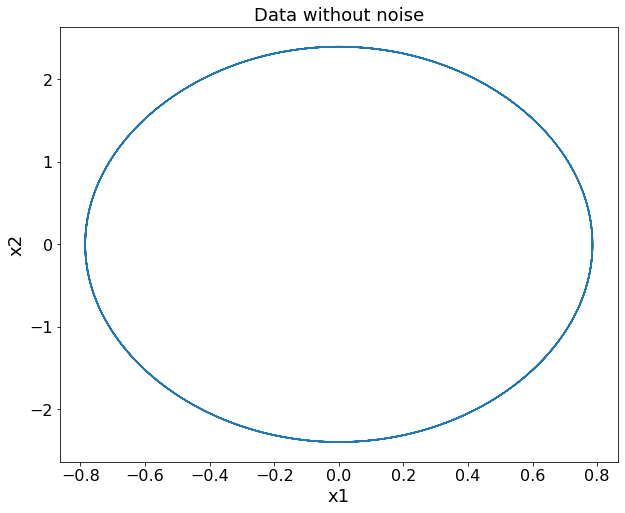

In [23]:
import matplotlib.pyplot as plt
X1, X2 = generate_data(np.pi/4, with_noise=False)
plt.figure(figsize=(10,8))
plt.title('Data without noise', fontsize=18)
plt.xlabel('x1', fontsize=18)
plt.ylabel('x2', fontsize=18)
plt.plot(X1, X2)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(X1_d, X2_d)
plt.show()

In [39]:
import statsmodels.api as sm

# Denoising the noisy data using HP filter
inits = [np.pi/3, np.pi/4, np.pi/5, np.pi/6]
for x_init in inits:
    X1, X2, h = generate_data(x_init, with_noise=True)
    _, X1_d = sm.tsa.filters.hpfilter(X1, 1600)
    _, X2_d = sm.tsa.filters.hpfilter(X2, 1600)
    x1_dot = (X1_d[1:]-X1_d[:-1])/h
    x2_dot = (X2_d[1:]-X2_d[:-1])/h
    x = np.column_stack((X1_d[:-1], X2_d[:-1]))
    y = np.column_stack((x1_dot, x2_dot))
    x_train = x[:4000]
    y_train = y[:4000]
    x_test = x[4000:]
    y_test = y[4000:]
    my_eql_model = EQL(inputSize=2,outputSize=2,numLayers=2)
    my_eql_model.build(learningRate=0.0001, method=Adam, loss='mse')
    my_eql_model.fit(x_train, y_train, numEpoch=5000, batchSize=20, reg=10**-3, verbose=1)

    print("\nFor x_init=", x_init, "and for window_length=", w)
    print(my_eql_model.getEquation())
    print("Final RMSE on training data = ", my_eql_model.evaluate(x_train,y_train))
    print("Final RMSE on test data = ", my_eql_model.evaluate(x_test,y_test))

Epoch 1/1250
4000/4000 [==============================] - 0s 77us/sample - loss: 0.4642 - rmse: 0.6784
Epoch 2/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.3676 - rmse: 0.6037
Epoch 3/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.2953 - rmse: 0.5409
Epoch 4/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.2404 - rmse: 0.4880
Epoch 5/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.1982 - rmse: 0.4432
Epoch 6/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.1655 - rmse: 0.4051
Epoch 7/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.1398 - rmse: 0.3727
Epoch 8/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.1191 - rmse: 0.3442
Epoch 9/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.1017 - rmse: 0.3178
Epoch 10/1250
4000/4000 [==============================] - 0s 42us/sample

Epoch 78/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0053 - rmse: 0.0722
Epoch 79/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0053 - rmse: 0.0724
Epoch 80/1250
4000/4000 [==============================] - ETA: 0s - loss: 0.0053 - rmse: 0.07 - 0s 41us/sample - loss: 0.0053 - rmse: 0.0723
Epoch 81/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0053 - rmse: 0.0722
Epoch 82/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0053 - rmse: 0.0722
Epoch 83/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0053 - rmse: 0.0723
Epoch 84/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0053 - rmse: 0.0723
Epoch 85/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0053 - rmse: 0.0722
Epoch 86/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0053 - rmse: 0.0722
Epoch 87/1250
4000/4000 [=

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0698
Epoch 231/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0699
Epoch 232/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0699
Epoch 233/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0699
Epoch 234/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0698
Epoch 235/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0698
Epoch 236/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0049 - rmse: 0.0698
Epoch 237/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0698
Epoch 238/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0049 - rmse: 0.0698
Epoch 239/1250
4000/4000 [==============================] - 0s 43us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0695
Epoch 384/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 385/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 386/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 387/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 388/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 389/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 390/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 391/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 392/1250
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 538/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 539/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 540/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 541/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 542/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 543/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 544/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 545/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 546/1250
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0692
Epoch 692/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 693/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 694/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 695/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 696/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0049 - rmse: 0.0694s - loss: 0.0049 - rmse: 0.06
Epoch 697/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 698/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0692
Epoch 699/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0049 - rmse: 0.0692
Epoch 700/1250
4000/4000 [===============

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 846/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 847/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0692
Epoch 848/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0048 - rmse: 0.0693
Epoch 849/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0048 - rmse: 0.0691
Epoch 850/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0048 - rmse: 0.0693
Epoch 851/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 852/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 853/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 854/1250
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0049 - rmse: 0.0692
Epoch 923/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0048 - rmse: 0.0691
Epoch 924/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 925/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 926/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 927/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 928/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 929/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0049 - rmse: 0.0692
Epoch 930/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0048 - rmse: 0.0693
Epoch 931/1250
4000/4000 [==============================] - 0s 38us/sa

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1076/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1077/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1078/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1079/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1080/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1081/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0048 - rmse: 0.0691
Epoch 1082/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1083/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1084/1250
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0048 - rmse: 0.0691
Epoch 1230/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1231/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0048 - rmse: 0.0691
Epoch 1232/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1233/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0048 - rmse: 0.0691
Epoch 1234/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1235/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0691
Epoch 1236/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1237/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0692
Epoch 1238/1250
4000/4000 [==============================] - 0

Epoch 133/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0086 - rmse: 0.0695
Epoch 134/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0086 - rmse: 0.0694
Epoch 135/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0086 - rmse: 0.0694
Epoch 136/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0086 - rmse: 0.0694
Epoch 137/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.0085 - rmse: 0.06 - 0s 45us/sample - loss: 0.0086 - rmse: 0.0694
Epoch 138/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0086 - rmse: 0.0694
Epoch 139/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0086 - rmse: 0.0694
Epoch 140/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0085 - rmse: 0.0695
Epoch 141/3500
4000/4000 [==============================] - 0s 47us/sample - loss: 0.0085 - rmse: 0.0694
Epoch 142/3500
40

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0078 - rmse: 0.0695
Epoch 288/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0077 - rmse: 0.0695
Epoch 289/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0077 - rmse: 0.0694
Epoch 290/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0077 - rmse: 0.0694
Epoch 291/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0077 - rmse: 0.0694
Epoch 292/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0077 - rmse: 0.0694
Epoch 293/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0076 - rmse: 0.0695
Epoch 294/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0076 - rmse: 0.0694
Epoch 295/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0076 - rmse: 0.0694
Epoch 296/3500
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 365/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 366/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 367/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 368/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 369/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 370/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 371/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 372/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 373/3500
4000/4000 [==============================] - 0s 43us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 519/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 520/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 521/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 522/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 523/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 524/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 525/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 526/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 527/3500
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 672/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 673/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 674/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 675/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 676/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 677/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 678/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 679/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 680/3500
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 826/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 827/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 828/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 829/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 830/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 831/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 832/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 833/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 834/3500
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 981/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 982/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 983/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 984/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 985/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 986/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 987/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 988/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 989/3500
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 1134/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1135/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1136/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 1137/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 1138/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1139/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 1140/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1141/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 1142/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1288/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1289/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 1290/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1291/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1292/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1293/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1294/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 1295/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1296/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1442/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 1443/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1444/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1445/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1446/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1447/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1448/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1449/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1450/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1596/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1597/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1598/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1599/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1600/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1601/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 1602/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1603/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1604/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 1673/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1674/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1675/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1676/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 1677/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1678/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1679/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 1680/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1681/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1827/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1828/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1829/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1830/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1831/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1832/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1833/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1834/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1835/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1979/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 1980/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1981/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1982/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1983/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1984/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1985/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 1986/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 1987/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2132/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2133/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2134/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2135/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2136/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2137/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2138/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2139/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2140/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2284/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2285/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2286/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2287/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2288/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2289/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 2290/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2291/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2292/3500
4000/4000 [==============================] - 0

Epoch 2436/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2437/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2438/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2439/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2440/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2441/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2442/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 2443/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2444/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2445/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 2514/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2515/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694s - loss: 0.0075 - rmse: 0.
Epoch 2516/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2517/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2518/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2519/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2520/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2521/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2522/3500
4000/4000 [========

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2666/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2667/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2668/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2669/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2670/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2671/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2672/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2673/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2674/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2820/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2821/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2822/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2823/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2824/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2825/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2826/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2827/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2828/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2973/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 2974/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2975/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2976/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 2977/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2978/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2979/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2980/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 2981/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 3127/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 3128/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 3129/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 3130/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3131/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 3132/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3133/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 3134/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 3135/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0695
Epoch 3281/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3282/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3283/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3284/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3285/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3286/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3287/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 3288/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 3289/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 3435/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3436/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3437/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3438/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3439/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 3440/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0075 - rmse: 0.0693
Epoch 3441/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3442/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0075 - rmse: 0.0694
Epoch 3443/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 89/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 90/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 91/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 92/250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 93/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 94/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 95/250
4000/4000 [==============================] - 0s 50us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 96/250
4000/4000 [==============================] - 0s 46us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 97/250
4000/4000 [==============================] - 0s 56us/sample - loss: 0.004

4000/4000 [==============================] - 0s 56us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 244/250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 245/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0049 - rmse: 0.0694
Epoch 246/250
4000/4000 [==============================] - 0s 49us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 247/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0049 - rmse: 0.0693s - loss: 0.0049 - rmse: 0.
Epoch 248/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 249/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0693
Epoch 250/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0694
Phase 3 (100% epochs) completed.
4000/4000 [==============================] - 0s 22us/sample - loss: 0.0049 - rmse: 0.0666
0.066614375

For x_init= 1.04719

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0030 - rmse: 0.0542
Epoch 140/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0541s - loss: 0.0030 - rmse: 0.05
Epoch 141/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0030 - rmse: 0.0542
Epoch 142/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0542s - loss: 0.0030 - rmse: 0.
Epoch 143/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0030 - rmse: 0.0541s - loss: 0.0030 - rmse: 
Epoch 144/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0541
Epoch 145/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0030 - rmse: 0.0541
Epoch 146/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0542
Epoch 147/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rm

4000/4000 [==============================] - 0s 57us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 291/1250
4000/4000 [==============================] - 0s 46us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 292/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0030 - rmse: 0.0541
Epoch 293/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0030 - rmse: 0.0541
Epoch 294/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0030 - rmse: 0.0541
Epoch 295/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 296/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0030 - rmse: 0.0541
Epoch 297/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 298/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 299/1250
4000/4000 [==============================] - 0s 47us/sa

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0030 - rmse: 0.0541
Epoch 445/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 446/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 447/1250
4000/4000 [==============================] - ETA: 0s - loss: 0.0030 - rmse: 0.05 - 0s 41us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 448/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 449/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 450/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 451/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 452/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 453/1250
4000/4000 [======

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 521/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 522/1250
4000/4000 [==============================] - ETA: 0s - loss: 0.0029 - rmse: 0.05 - 0s 38us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 523/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0540s - loss: 0.0030 - rmse: 0.
Epoch 524/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 525/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 526/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0030 - rmse: 0.0541s - loss: 0.0029 - rmse: 0.05
Epoch 527/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0030 - rmse: 0.0539
Epoch 528/1250
4000/4000 [==============================] - 0s 37us/sample - loss

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 597/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 598/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0029 - rmse: 0.0540
Epoch 599/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0029 - rmse: 0.0540
Epoch 600/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 601/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 602/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0030 - rmse: 0.0539
Epoch 603/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0030 - rmse: 0.0539
Epoch 604/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0030 - rmse: 0.0540
Epoch 605/1250
4000/4000 [==============================] - 0s 38us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 748/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 749/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0540
Epoch 750/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 751/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 752/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 753/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 754/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 755/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0029 - rmse: 0.0540
Epoch 756/1250
4000/4000 [==============================] - 0s 39us/sa

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539s - loss: 0.0029 - rmse: 0.
Epoch 900/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 901/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 902/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 903/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 904/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 905/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 906/1250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 907/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 908/1250
4000/4000 [=================

4000/4000 [==============================] - ETA: 0s - loss: 0.0031 - rmse: 0.05 - ETA: 0s - loss: 0.0029 - rmse: 0.05 - 0s 36us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 1052/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1053/1250
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1054/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1055/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0029 - rmse: 0.0539s - loss: 0.0029 - rmse: 0.05
Epoch 1056/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1057/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1058/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0539
Epoch 1059/1250
4000/4000 [==============================] - 0s

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1203/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1204/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1205/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0537s - loss: 0.0029 - rmse: 0.05
Epoch 1206/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1207/1250
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0029 - rmse: 0.0537
Epoch 1208/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0029 - rmse: 0.0537
Epoch 1209/1250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0029 - rmse: 0.0538
Epoch 1210/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0537
Epoch 1211/1250
4000/4000 [======

4000/4000 [==============================] - 0s 37us/sample - loss: 0.0072 - rmse: 0.0535
Epoch 106/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0071 - rmse: 0.0536
Epoch 107/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0070 - rmse: 0.0536
Epoch 108/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0070 - rmse: 0.0536
Epoch 109/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0069 - rmse: 0.0535
Epoch 110/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0069 - rmse: 0.0535
Epoch 111/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0068 - rmse: 0.0536
Epoch 112/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0068 - rmse: 0.0535
Epoch 113/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0068 - rmse: 0.0535
Epoch 114/3500
4000/4000 [==============================] - 0s 37us/sa

4000/4000 [==============================] - 0s 37us/sample - loss: 0.0062 - rmse: 0.0533
Epoch 260/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0062 - rmse: 0.0535
Epoch 261/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0062 - rmse: 0.0533
Epoch 262/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0062 - rmse: 0.0534
Epoch 263/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0062 - rmse: 0.0534
Epoch 264/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0062 - rmse: 0.0534
Epoch 265/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0062 - rmse: 0.0533
Epoch 266/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0062 - rmse: 0.0534
Epoch 267/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0062 - rmse: 0.0534
Epoch 268/3500
4000/4000 [==============================] - 0s 36us/sa

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 414/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 415/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 416/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 417/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 418/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 419/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 420/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 421/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 422/3500
4000/4000 [==============================] - 0s 37us/sa

Epoch 490/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 491/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 492/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 493/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 494/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 495/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 496/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 497/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 498/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 499/3500
4000/4000 [=============================

4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 569/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 570/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 571/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 572/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 573/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 574/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 575/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 576/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 577/3500
4000/4000 [==============================] - 0s 36us/sa

4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0532
Epoch 723/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 724/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 725/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 726/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 727/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 728/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 729/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533s - loss: 0.0056 - rmse: 0.
Epoch 730/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 731/3500
4000/4000 [=================

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 876/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 877/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 878/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 879/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 880/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 881/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 882/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 883/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 884/3500
4000/4000 [==============================] - 0s 37us/sa

4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1029/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1030/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1031/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1032/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0532
Epoch 1033/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1034/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1035/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1036/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1037/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1182/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1183/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1184/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1185/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1186/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1187/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1188/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1189/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1190/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1259/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1260/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1261/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1262/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1263/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1264/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1265/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1266/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1267/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1413/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0534s - loss: 0.0055 - rmse: 0.05
Epoch 1414/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1415/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1416/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1417/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1418/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1419/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1420/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1421/3500
4000/4000 [======

4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1566/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1567/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1568/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1569/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1570/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1571/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1572/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1573/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1574/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1717/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1718/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1719/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1720/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533s - loss: 0.0058 - rmse: 0.
Epoch 1721/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1722/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1723/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1724/3500
4000/4000 [==============================] - 0s 36us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1725/3500
4000/4000 [========

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1870/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1871/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1872/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1873/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1874/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1875/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1876/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1877/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1878/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533s - loss: 0.0055 - rmse: 0.05
Epoch 1947/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1948/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1949/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1950/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1951/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1952/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1953/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 1954/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 1955/3500
4000/4000 [======

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2100/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2101/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0532
Epoch 2102/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533s - loss: 0.0055 - rmse: 0.
Epoch 2103/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.0055 - rmse: 0.05 - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2104/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2105/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2106/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2107/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.05

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2252/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533s - loss: 0.0055 - rmse: 
Epoch 2253/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2254/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2255/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2256/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2257/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2258/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2259/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0532
Epoch 2260/3500
4000/4000 [==========

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2402/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2403/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2404/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2405/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2406/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2407/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2408/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2409/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2410/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2554/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2555/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0532
Epoch 2556/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2557/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2558/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2559/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2560/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2561/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2562/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2706/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2707/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2708/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2709/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2710/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2711/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2712/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2713/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2714/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2859/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2860/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2861/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2862/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2863/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2864/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2865/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 2866/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 2867/3500
4000/4000 [==============================] - 0

Epoch 3011/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3012/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 3013/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3014/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3015/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3016/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3017/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3018/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3019/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3020/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3166/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3167/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3168/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533s - loss: 0.0056 - rmse: 
Epoch 3169/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0532
Epoch 3170/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 3171/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.0056 - rmse: 0.05 - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3172/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3173/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3313/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 3314/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3315/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3316/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3317/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3318/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3319/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533s - loss: 0.0056 - rmse: 0.05
Epoch 3320/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3321/3500
4000/4000 [======

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3462/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3463/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3464/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3465/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3466/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 3467/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3468/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0055 - rmse: 0.0534
Epoch 3469/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0055 - rmse: 0.0533
Epoch 3470/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 39/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 40/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 41/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0532
Epoch 42/250
4000/4000 [==============================] - ETA: 0s - loss: 0.0029 - rmse: 0.05 - 0s 42us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 43/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0532
Epoch 44/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 45/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 46/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 47/250
4000/4000 [========================

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 118/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 119/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 120/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 121/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 122/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0533
Epoch 123/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0029 - rmse: 0.0532
Epoch 124/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0029 - rmse: 0.0534
Epoch 125/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0029 - rmse: 0.0532
Epoch 126/250
4000/4000 [==============================] - 0s 41us/sample - lo

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0088 - rmse: 0.0935
Epoch 17/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0062 - rmse: 0.0785
Epoch 18/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0045 - rmse: 0.0665
Epoch 19/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0034 - rmse: 0.0578
Epoch 20/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0027 - rmse: 0.0519
Epoch 21/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0024 - rmse: 0.0485
Epoch 22/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0022 - rmse: 0.0465
Epoch 23/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0021 - rmse: 0.0453
Epoch 24/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0020 - rmse: 0.0445
Epoch 25/1250
4000/4000 [==============================] - 0s 42us/sample - lo

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 173/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0408
Epoch 174/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0408
Epoch 175/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 176/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 177/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0408
Epoch 178/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0408
Epoch 179/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 180/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0408
Epoch 181/1250
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0408
Epoch 329/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 330/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 331/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 332/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 333/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 334/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 335/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 336/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 337/1250
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 483/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 484/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 485/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 486/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 487/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 488/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 489/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 490/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 491/1250
4000/4000 [==============================] - ETA: 0s - 

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 638/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 639/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 640/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 641/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 642/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 643/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 644/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 645/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 646/1250
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 794/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 795/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 796/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 797/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 798/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 799/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 800/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 801/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 802/1250
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 950/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 951/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 952/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 953/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 954/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 955/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 956/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 957/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0017 - rmse: 0.0407
Epoch 958/1250
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 1104/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 1105/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 1106/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 1107/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 1108/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0017 - rmse: 0.0406s - loss: 0.0017 - rmse: 0.
Epoch 1109/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 1110/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 1111/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 1112/1250
4000/4000 [========

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0119 - rmse: 0.0410
Epoch 6/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0116 - rmse: 0.0410
Epoch 7/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0113 - rmse: 0.0409
Epoch 8/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0110 - rmse: 0.0409
Epoch 9/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0107 - rmse: 0.0409
Epoch 10/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0104 - rmse: 0.0408
Epoch 11/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0101 - rmse: 0.0408
Epoch 12/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0098 - rmse: 0.0408
Epoch 13/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0096 - rmse: 0.0408
Epoch 14/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 

Epoch 84/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0407
Epoch 85/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0049 - rmse: 0.0407
Epoch 86/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0048 - rmse: 0.0407
Epoch 87/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0407
Epoch 88/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0406
Epoch 89/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0048 - rmse: 0.0407
Epoch 90/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0047 - rmse: 0.0407
Epoch 91/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0047 - rmse: 0.0407
Epoch 92/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0047 - rmse: 0.0407
Epoch 93/3500
4000/4000 [==============================] - 0s 42

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 239/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 240/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 241/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 242/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 243/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 244/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 245/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 246/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 247/3500
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 393/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 394/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 395/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 396/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 397/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 398/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 399/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 400/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 401/3500
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 549/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 550/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 551/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 552/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 553/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 554/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 555/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 556/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 557/3500
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 705/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 706/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.0043 - rmse: 0.04 - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 707/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 708/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 709/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 710/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 711/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 712/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 713/3500
4000/4000 [======

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 859/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 860/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 861/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 862/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 863/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 864/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 865/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 866/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 867/3500
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1013/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1014/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1015/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1016/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1017/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1018/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1019/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1020/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 1021/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1090/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1091/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1092/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1093/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1094/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1095/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1096/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1097/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1098/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1243/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1244/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1245/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1246/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1247/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1248/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1249/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1250/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1251/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1397/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1398/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1399/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 1400/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1401/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1402/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 1403/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1404/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1405/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1551/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 1552/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1553/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 1554/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1555/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1556/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1557/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1558/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1559/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1628/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1629/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1630/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1631/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1632/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1633/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1634/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1635/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1636/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1781/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 1782/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1783/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1784/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1785/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1786/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1787/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1788/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 1789/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1935/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1936/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1937/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1938/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1939/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1940/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 1941/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1942/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 1943/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2089/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2090/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2091/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2092/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2093/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2094/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 2095/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2096/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2097/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 2243/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 2244/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2245/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2246/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2247/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2248/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 2249/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2250/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2251/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0043 - rmse: 0.0406s - loss: 0.0043 - rmse: 0.04
Epoch 2397/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2398/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2399/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2400/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2401/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2402/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2403/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 2404/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2405/3500
4000/4000 [======

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 2551/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2552/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2553/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2554/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2555/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2556/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2557/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2558/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2559/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2705/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2706/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2707/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2708/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2709/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2710/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2711/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2712/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2713/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 2859/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 2860/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2861/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2862/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2863/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2864/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2865/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2866/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 2867/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3011/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406s - loss: 0.0043 - rmse: 0.04
Epoch 3012/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3013/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3014/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406s - loss: 0.0044 - rmse: 0.
Epoch 3015/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3016/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3017/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3018/3500
4000/4000 [==============================] - 0s 37us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 3083/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3084/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.0043 - rmse: 0.04 - 0s 38us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 3085/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3086/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 3087/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3088/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3089/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3090/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.0043 - rmse: 0.04 - 0s 38us/sample - loss: 0.0043 -

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 3231/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3232/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3233/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3234/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3235/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3236/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3237/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3238/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3239/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - ETA: 0s - loss: 0.0043 - rmse: 0.04 - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3381/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3382/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406s - loss: 0.0043 - rmse: 0.04
Epoch 3383/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3384/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0407
Epoch 3385/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0043 - rmse: 0.0406s - loss: 0.0043 - rmse: 0.04
Epoch 3386/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3387/3500
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0043 - rmse: 0.0406
Epoch 3388/3500
4000/4000 [==============================] - 0s 38us/sam

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 28/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 29/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 30/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 31/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 32/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 33/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 34/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 35/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 36/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.001

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0017 - rmse: 0.0405A: 0s - loss: 0.0016 - rmse: 0.
Epoch 184/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 185/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 186/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 187/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 188/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 189/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 190/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 191/250
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0017 - rmse: 0.0405
Epoch 192/250
4000/4000 [======================

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 86/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 87/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0361
Epoch 88/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0361
Epoch 89/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0013 - rmse: 0.0361
Epoch 90/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 91/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 92/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 93/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 94/1250
4000/4000 [==============================] - 0s 44us/sample - lo

Epoch 163/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 164/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 165/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 166/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 167/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 168/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 169/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 170/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 171/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 172/1250
4000/4000 [=============================

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 318/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 319/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 320/1250
4000/4000 [==============================] - 0s 46us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 321/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 322/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 323/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 324/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 325/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 326/1250
4000/4000 [==============================] - 0s 44us/sa

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 474/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 475/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 476/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 477/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 478/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 479/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 480/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 481/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 482/1250
4000/4000 [==============================] - 0s 43us/sa

4000/4000 [==============================] - 0s 47us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 629/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 630/1250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 631/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 632/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 633/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 634/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0360
Epoch 635/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 636/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359s - loss: 0.0013 - rmse: 0.
Epoch 637/1250
4000/4000 [=================

4000/4000 [==============================] - ETA: 0s - loss: 0.0013 - rmse: 0.03 - 0s 41us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 784/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 785/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 786/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 787/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 788/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 789/1250
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 790/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 791/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 792/1250
4000/4000 [======

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 938/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 939/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 940/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 941/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 942/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 943/1250
4000/4000 [==============================] - 0s 46us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 944/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 945/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 946/1250
4000/4000 [==============================] - 0s 43us/sa

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 1016/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1017/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1018/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1019/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1020/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1021/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1022/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1023/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1024/1250
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 45us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1170/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 1171/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1172/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 1173/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 1174/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1175/1250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1176/1250
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1177/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1178/1250
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1247/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 1248/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1249/1250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0359
Epoch 1250/1250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0359
Phase 1 (25% epochs) completed.
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0344
0.034371324
Epoch 1/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0133 - rmse: 0.0362
Epoch 2/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0125 - rmse: 0.0364
Epoch 3/3500
4000/4000 [==============================] - 0s 56us/sample - loss: 0.0119 - rmse: 0.0364
Epoch 4/3500
4000/4000 [===================

Epoch 73/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0052 - rmse: 0.0361
Epoch 74/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0051 - rmse: 0.0360
Epoch 75/3500
4000/4000 [==============================] - 0s 46us/sample - loss: 0.0051 - rmse: 0.0360
Epoch 76/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0051 - rmse: 0.0360
Epoch 77/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0050 - rmse: 0.0360
Epoch 78/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0050 - rmse: 0.0360
Epoch 79/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0049 - rmse: 0.0360
Epoch 80/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0049 - rmse: 0.0360
Epoch 81/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0049 - rmse: 0.0360
Epoch 82/3500
4000/4000 [==============================] - 0s 43

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 229/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 230/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 231/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 232/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 233/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 234/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 235/3500
4000/4000 [==============================] - ETA: 0s - loss: 0.0039 - rmse: 0.03 - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 236/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 237/3500
4000/4000 [======

4000/4000 [==============================] - 0s 46us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 384/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358s - loss: 0.0039 - rmse: 
Epoch 385/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 386/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 387/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 388/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 389/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 390/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 391/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 392/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 538/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 539/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 540/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 541/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 542/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 543/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 544/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 545/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 546/3500
4000/4000 [==============================] - 0s 41us/sa

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 694/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 695/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 696/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 697/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359s - loss: 0.0039 - rmse: 0.03
Epoch 698/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 699/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 700/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 701/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 702/3500
4000/4000 [===============

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 849/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 850/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 851/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 852/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 853/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 854/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 855/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 856/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 857/3500
4000/4000 [==============================] - 0s 42us/sa

4000/4000 [==============================] - 0s 47us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1004/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1005/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1006/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1007/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1008/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1009/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1010/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1011/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1012/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1081/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1082/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1083/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1084/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1085/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1086/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1087/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1088/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1089/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1234/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1235/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1236/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1237/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1238/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1239/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1240/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1241/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1242/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1386/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1387/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1388/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1389/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1390/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1391/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1392/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1393/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1394/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1539/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1540/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1541/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1542/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1543/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1544/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1545/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1546/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1547/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1616/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1617/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1618/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1619/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1620/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1621/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1622/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1623/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1624/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1770/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1771/3500
4000/4000 [==============================] - 0s 48us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1772/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1773/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1774/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1775/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1776/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1777/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1778/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1924/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1925/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1926/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1927/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1928/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1929/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 1930/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1931/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 1932/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2077/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2078/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2079/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2080/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2081/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2082/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2083/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2084/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2085/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2154/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2155/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2156/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2157/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2158/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2159/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2160/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2161/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2162/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2307/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2308/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2309/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2310/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2311/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2312/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2313/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2314/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2315/3500
4000/4000 [==============================] - E

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2458/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2459/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2460/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2461/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2462/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2463/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2464/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2465/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2466/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2609/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2610/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2611/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359s - loss: 0.0039 - rmse: 0.
Epoch 2612/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2613/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2614/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2615/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2616/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2617/3500
4000/4000 [========

Epoch 2685/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2686/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2687/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2688/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2689/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2690/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359s - loss: 0.0039 - rmse: 0.
Epoch 2691/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2692/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359s - loss: 0.0039 - rmse: 0.03
Epoch 2693/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rms

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2838/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2839/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2840/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2841/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2842/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2843/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2844/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2845/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2846/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2990/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2991/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2992/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2993/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 2994/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2995/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2996/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2997/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 2998/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 3142/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3143/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 3144/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3145/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3146/3500
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 3147/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3148/3500
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 3149/3500
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3150/3500
4000/4000 [==============================] - 0

4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3294/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3295/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3296/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3297/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3298/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3299/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3300/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 3301/3500
4000/4000 [==============================] - 0s 44us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3302/3500
4000/4000 [==============================] - 0

Epoch 3444/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3445/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3446/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3447/3500
4000/4000 [==============================] - 0s 45us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3448/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3449/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0358
Epoch 3450/3500
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3451/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3452/3500
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0039 - rmse: 0.0359
Epoch 3453/3500
4000/4000 [===================

4000/4000 [==============================] - 0s 39us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 20/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 21/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 22/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 23/250
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 24/250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 25/250
4000/4000 [==============================] - 0s 43us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 26/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 27/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 28/250
4000/4000 [==============================] - 0s 42us/sample - loss: 0.001

4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 173/250
4000/4000 [==============================] - 0s 39us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 174/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 175/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 176/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 177/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0357
Epoch 178/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 179/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0358
Epoch 180/250
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0013 - rmse: 0.0357s - loss: 0.0013 - rmse: 0.
Epoch 181/250
4000/4000 [==========================

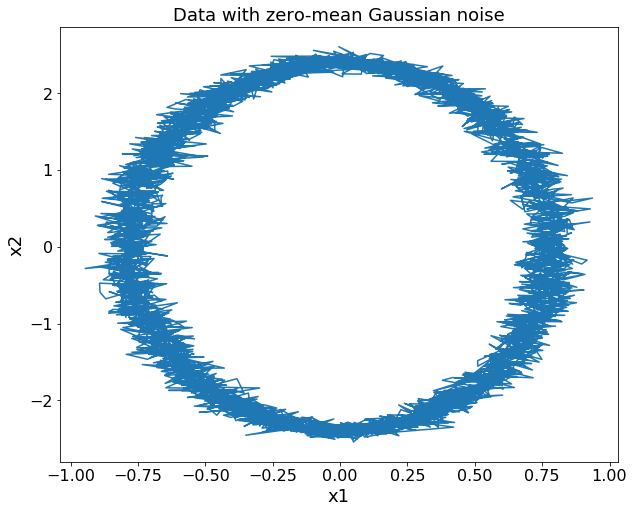

In [24]:
plt.figure(figsize=(10,8))
X1, X2 = generate_data(np.pi/4)
plt.title('Data with zero-mean Gaussian noise', fontsize=18)
plt.xlabel('x1', fontsize=18)
plt.ylabel('x2', fontsize=18)
plt.plot(X1, X2)
plt.show()

In [2]:
# Hodrick-Prescott filter
plt.figure(figsize=(10,8))
import statsmodels.api as sm
_, X1_d = sm.tsa.filters.hpfilter(X1, 1600)
_, X2_d = sm.tsa.filters.hpfilter(X2, 1600)
plt.title('Data after denoising using H-P filter, lambda=1600', fontsize=18)
plt.xlabel('x1', fontsize=18)
plt.ylabel('x2', fontsize=18)
plt.plot(X1_d, X2_d)
plt.show()

NameError: name 'plt' is not defined

In [19]:
import matplotlib as mpl

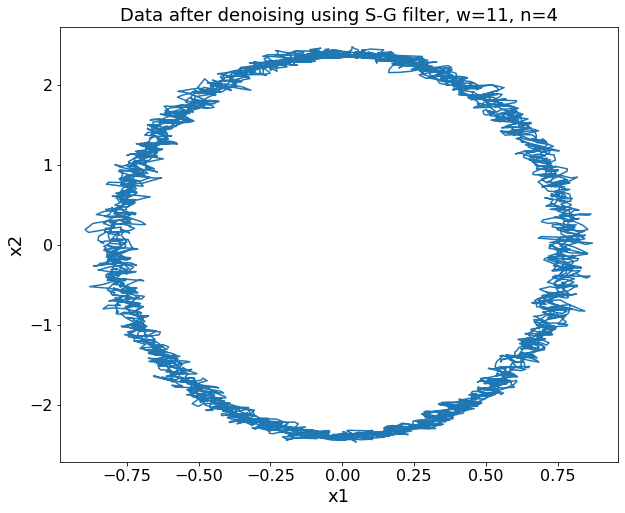

In [22]:
from scipy.signal import savgol_filter
w=11
X1, X2 = generate_data(np.pi/4)
X1_d = savgol_filter(X1,window_length=w,polyorder=4)
X2_d = savgol_filter(X2,window_length=w,polyorder=4)
plt.figure(figsize=(10,8))

plt.title('Data after denoising using S-G filter, w=11, n=4', fontsize=18)
plt.xlabel('x1', fontsize=18)
plt.ylabel('x2', fontsize=18)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
plt.plot(X1_d, X2_d)
plt.show()

In [7]:
import numpy as np
x1 = np.linspace(np.pi/60, np.pi/5, num=800)
x2 = np.linspace(1,5, num=800)
out = np.sin(x1)*x2
x = np.column_stack((x1, x2))
y = out
my_eql_model4 = EQL(inputSize=2,outputSize=1,numLayers=2)
my_eql_model4.build(learningRate=0.0001, method=Adam, loss='mse')
my_eql_model4.fit(x, y, numEpoch=2000, batchSize=20, reg=10**-3, verbose=1)

W0601 16:05:03.271301 40152 deprecation.py:506] From c:\users\vasistha singhal\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/500
800/800 [==============================] - 0s 208us/sample - loss: 0.7297 - rmse: 0.8432
Epoch 2/500
800/800 [==============================] - 0s 44us/sample - loss: 0.6327 - rmse: 0.7848
Epoch 3/500
800/800 [==============================] - 0s 42us/sample - loss: 0.5470 - rmse: 0.7320
Epoch 4/500
800/800 [==============================] - 0s 36us/sample - loss: 0.4719 - rmse: 0.6797
Epoch 5/500
800/800 [==============================] - 0s 38us/sample - loss: 0.4057 - rmse: 0.6278
Epoch 6/500
800/800 [==============================] - 0s 38us/sample - loss: 0.3494 - rmse: 0.5804
Epoch 7/500
800/800 [==============================] - 0s 36us/sample - loss: 0.2997 - rmse: 0.5379
Epoch 8/500
800/800 [==============================] - 0s 37us/sample - loss: 0.2582 - rmse: 0.5018
Epoch 9/500
800/800 [==============================] - 0s 37us/sample - loss: 0.2233 - rmse: 0.4655
Epoch 10/500
800/800 [==============================] - 0s 37us/sample - loss: 0.1935 - rmse: 0.433

800/800 [==============================] - 0s 39us/sample - loss: 0.0019 - rmse: 0.0430
Epoch 159/500
800/800 [==============================] - 0s 40us/sample - loss: 0.0019 - rmse: 0.0426
Epoch 160/500
800/800 [==============================] - 0s 41us/sample - loss: 0.0018 - rmse: 0.0422
Epoch 161/500
800/800 [==============================] - 0s 39us/sample - loss: 0.0018 - rmse: 0.0419
Epoch 162/500
800/800 [==============================] - ETA: 0s - loss: 0.0019 - rmse: 0.04 - 0s 36us/sample - loss: 0.0018 - rmse: 0.0418
Epoch 163/500
800/800 [==============================] - ETA: 0s - loss: 0.0018 - rmse: 0.04 - 0s 37us/sample - loss: 0.0018 - rmse: 0.0415
Epoch 164/500
800/800 [==============================] - 0s 37us/sample - loss: 0.0017 - rmse: 0.0412
Epoch 165/500
800/800 [==============================] - 0s 37us/sample - loss: 0.0017 - rmse: 0.0408
Epoch 166/500
800/800 [==============================] - 0s 37us/sample - loss: 0.0017 - rmse: 0.0406
Epoch 167/500
800/80

800/800 [==============================] - 0s 35us/sample - loss: 2.6155e-05 - rmse: 0.0051
Epoch 311/500
800/800 [==============================] - 0s 38us/sample - loss: 2.5867e-05 - rmse: 0.0050
Epoch 312/500
800/800 [==============================] - 0s 35us/sample - loss: 2.5678e-05 - rmse: 0.0050
Epoch 313/500
800/800 [==============================] - 0s 37us/sample - loss: 2.4974e-05 - rmse: 0.0050
Epoch 314/500
800/800 [==============================] - 0s 36us/sample - loss: 2.4609e-05 - rmse: 0.0049
Epoch 315/500
800/800 [==============================] - 0s 36us/sample - loss: 2.5413e-05 - rmse: 0.0050
Epoch 316/500
800/800 [==============================] - 0s 37us/sample - loss: 2.4319e-05 - rmse: 0.0049
Epoch 317/500
800/800 [==============================] - 0s 35us/sample - loss: 2.4068e-05 - rmse: 0.0048
Epoch 318/500
800/800 [==============================] - 0s 36us/sample - loss: 2.4001e-05 - rmse: 0.0048
Epoch 319/500
800/800 [==============================] - 0s 

800/800 [==============================] - 0s 37us/sample - loss: 2.1512e-05 - rmse: 0.0046
Epoch 386/500
800/800 [==============================] - 0s 40us/sample - loss: 2.1503e-05 - rmse: 0.0046
Epoch 387/500
800/800 [==============================] - 0s 40us/sample - loss: 2.1543e-05 - rmse: 0.0046
Epoch 388/500
800/800 [==============================] - 0s 41us/sample - loss: 2.1203e-05 - rmse: 0.0046
Epoch 389/500
800/800 [==============================] - 0s 41us/sample - loss: 2.0957e-05 - rmse: 0.0045
Epoch 390/500
800/800 [==============================] - 0s 42us/sample - loss: 2.1638e-05 - rmse: 0.0046
Epoch 391/500
800/800 [==============================] - 0s 40us/sample - loss: 2.1677e-05 - rmse: 0.0046
Epoch 392/500
800/800 [==============================] - 0s 36us/sample - loss: 2.2237e-05 - rmse: 0.0046
Epoch 393/500
800/800 [==============================] - 0s 36us/sample - loss: 2.0936e-05 - rmse: 0.0045
Epoch 394/500
800/800 [==============================] - 0s 

800/800 [==============================] - 0s 41us/sample - loss: 0.0051 - rmse: 0.0084
Epoch 34/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0050 - rmse: 0.0084
Epoch 35/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0050 - rmse: 0.0083
Epoch 36/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0083
Epoch 37/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0049 - rmse: 0.0082
Epoch 38/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0048 - rmse: 0.0082
Epoch 39/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0047 - rmse: 0.0082
Epoch 40/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0047 - rmse: 0.0082
Epoch 41/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0046 - rmse: 0.0081
Epoch 42/1400
800/800 [==============================] - 0s 38us/sample - loss: 0.0046 - rmse: 0

800/800 [==============================] - 0s 41us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 190/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 191/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 192/1400
800/800 [==============================] - 0s 38us/sample - loss: 0.0025 - rmse: 0.0067
Epoch 193/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0025 - rmse: 0.0065
Epoch 194/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 195/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0025 - rmse: 0.0065
Epoch 196/1400
800/800 [==============================] - ETA: 0s - loss: 0.0025 - rmse: 0.00 - 0s 40us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 197/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0025 - rmse: 0.0065
Epoch 198/1400
800/800 [==========================

Epoch 267/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0025 - rmse: 0.0068
Epoch 268/1400
800/800 [==============================] - ETA: 0s - loss: 0.0024 - rmse: 0.00 - 0s 40us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 269/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 270/1400
800/800 [==============================] - 0s 38us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 271/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 272/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 273/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0025 - rmse: 0.0066
Epoch 274/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 275/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 276/1400
800/800 [===========

800/800 [==============================] - 0s 40us/sample - loss: 0.0024 - rmse: 0.0065
Epoch 346/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 347/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 348/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 349/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 350/1400
800/800 [==============================] - ETA: 0s - loss: 0.0024 - rmse: 0.00 - 0s 39us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 351/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 352/1400
800/800 [==============================] - ETA: 0s - loss: 0.0024 - rmse: 0.00 - 0s 40us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 353/1400
800/800 [==============================] - 0s 38us/sample - loss: 0.0024 - rmse: 0.0066
Epoch 354/14

Epoch 501/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0020 - rmse: 0.0066
Epoch 502/1400
800/800 [==============================] - 0s 44us/sample - loss: 0.0020 - rmse: 0.0066
Epoch 503/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0020 - rmse: 0.0066
Epoch 504/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0020 - rmse: 0.0065
Epoch 505/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0020 - rmse: 0.0066
Epoch 506/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0020 - rmse: 0.0066
Epoch 507/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0020 - rmse: 0.0066
Epoch 508/1400
800/800 [==============================] - 0s 37us/sample - loss: 0.0020 - rmse: 0.0066
Epoch 509/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0020 - rmse: 0.0066
Epoch 510/1400
800/800 [==============================] - ETA: 0s - loss:

800/800 [==============================] - 0s 41us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 659/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 660/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 661/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 662/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 663/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 664/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 665/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 666/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 667/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0016 

800/800 [==============================] - 0s 39us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 816/1400
800/800 [==============================] - 0s 38us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 817/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 818/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 819/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 820/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 821/1400
800/800 [==============================] - 0s 37us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 822/1400
800/800 [==============================] - 0s 38us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 823/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 824/1400
800/800 [==============================] - 0s 37us/sample - loss: 0.0016 

Epoch 973/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 974/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 975/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 976/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 977/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 978/1400
800/800 [==============================] - 0s 41us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 979/1400
800/800 [==============================] - 0s 42us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 980/1400
800/800 [==============================] - 0s 40us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 981/1400
800/800 [==============================] - 0s 39us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 982/1400
800/800 [==============================] - 0s 44us/sample 

800/800 [==============================] - 0s 37us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1126/1400
800/800 [==============================] - 0s 36us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1127/1400
800/800 [==============================] - 0s 36us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1128/1400
800/800 [==============================] - 0s 36us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1129/1400
800/800 [==============================] - 0s 36us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1130/1400
800/800 [==============================] - 0s 35us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 1131/1400
800/800 [==============================] - 0s 35us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1132/1400
800/800 [==============================] - 0s 35us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1133/1400
800/800 [==============================] - 0s 37us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 1134/1400
800/800 [==============================] - ETA: 0s - loss: 0.001

800/800 [==============================] - 0s 35us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 1282/1400
800/800 [==============================] - 0s 36us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1283/1400
800/800 [==============================] - 0s 35us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1284/1400
800/800 [==============================] - 0s 36us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1285/1400
800/800 [==============================] - 0s 35us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1286/1400
800/800 [==============================] - 0s 36us/sample - loss: 0.0016 - rmse: 0.0067
Epoch 1287/1400
800/800 [==============================] - 0s 35us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 1288/1400
800/800 [==============================] - 0s 36us/sample - loss: 0.0016 - rmse: 0.0065
Epoch 1289/1400
800/800 [==============================] - 0s 35us/sample - loss: 0.0016 - rmse: 0.0066
Epoch 1290/1400
800/800 [==============================] - 0s 35us/sample - loss

800/800 [==============================] - 0s 39us/sample - loss: 0.0026 - rmse: 0.0508
Epoch 37/100
800/800 [==============================] - 0s 39us/sample - loss: 0.0026 - rmse: 0.0507
Epoch 38/100
800/800 [==============================] - 0s 39us/sample - loss: 0.0026 - rmse: 0.0507
Epoch 39/100
800/800 [==============================] - ETA: 0s - loss: 0.0028 - rmse: 0.05 - 0s 39us/sample - loss: 0.0026 - rmse: 0.0506
Epoch 40/100
800/800 [==============================] - 0s 40us/sample - loss: 0.0026 - rmse: 0.0506
Epoch 41/100
800/800 [==============================] - 0s 39us/sample - loss: 0.0026 - rmse: 0.0507
Epoch 42/100
800/800 [==============================] - 0s 39us/sample - loss: 0.0026 - rmse: 0.0507
Epoch 43/100
800/800 [==============================] - 0s 38us/sample - loss: 0.0026 - rmse: 0.0506
Epoch 44/100
800/800 [==============================] - 0s 38us/sample - loss: 0.0026 - rmse: 0.0507
Epoch 45/100
800/800 [==============================] - 0s 41us/sa

In [8]:
print(my_eql_model4.getEquation())

(2,) (1, 2)
Matrix([[0.11575*x2**2]])


In [9]:
x1_test = np.linspace(np.pi/5,np.pi/2,num=100)
x2_test = np.linspace(5,6,num=100)
x_test = np.column_stack((x1_test, x2_test))
y_test = np.sin(x1_test)*x2_test

In [10]:
print("Final RMSE on training data = ", my_eql_model4.evaluate(x,y))
print("Final RMSE on test data = ", my_eql_model4.evaluate(x_test,y_test))

Final RMSE on training data =  0.0449651
Final RMSE on test data =  1.2456938
